# main nootbook to run

## installaions

## imports

In [33]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit,
    GridSearchCV,
    train_test_split,
    cross_validate,
    cross_val_score,
)
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklift.models import SoloModel

# from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re
from sklift.metrics import qini_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from functools import reduce

import matplotlib.pyplot as plt

In [34]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [35]:
from src.data_handler import DataHandler

## data handling

### data loading

In [36]:
# ----------------------------
# Load data
# ----------------------------
app_usage = pd.read_csv(repo_root / "data" / "train" / "app_usage.csv")
web_visits = pd.read_csv(repo_root / "data" / "train" / "web_visits.csv")
claims = pd.read_csv(repo_root / "data" / "train" / "claims.csv")
churn_labels = pd.read_csv(repo_root / "data" / "train" / "churn_labels.csv")
test_app_usage = pd.read_csv(repo_root / "data" / "test" / "test_app_usage.csv")
test_web_visits = pd.read_csv(repo_root / "data" / "test" / "test_web_visits.csv")
test_claims = pd.read_csv(repo_root / "data" / "test" / "test_claims.csv")
test_churn_labels = pd.read_csv(repo_root / "data" / "test" / "test_churn_labels.csv")

### data preprocess

In [37]:
train_data_handler = DataHandler(day_first_web=True)
test_data_handler = DataHandler(day_first_web=False)
X_train, y_train, treatment_train = train_data_handler.get_data(
    app_usage, web_visits, claims, churn_labels
)
X_test, y_test, treatment_test = test_data_handler.get_data(test_app_usage, test_web_visits, test_claims, test_churn_labels)



c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_usage_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_web_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_h

Feature matrix X shape: (10000, 31)
Target y distribution:
 y
0    7979
1    2021
Name: count, dtype: int64
Treatment distribution:
 treatment
0    6016
1    3984
Name: count, dtype: int64


c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_usage_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_web_trend).reset_index()


Feature matrix X shape: (10000, 31)
Target y distribution:
 y
0    7996
1    2004
Name: count, dtype: int64
Treatment distribution:
 treatment
0    6111
1    3889
Name: count, dtype: int64


c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:238: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_claims_trend).reset_index()


In [38]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
treatment_train = treatment_train.fillna(0)
treatment_test = treatment_test.fillna(0)

     DATASET HEALTH CHECK STARTING     

--- 1. Column Consistency Check ---
✅ Column names are consistent across both datasets.
✅ Column order for common columns is the same.

--- 2. Missing Value (NaN) Check ---
✅ No NaNs found in X_train.

✅ No NaNs found in X_test.

--- 3. Data Drift Analysis and Visualization ---
Analyzing 31 numerical and 0 categorical features for drift.

> Numerical Drift (Distribution Shift):
  ✅ has_icd_H10_9: Mean shift is acceptable (-0.01)
  ✅ unique_categories: Mean shift is acceptable (0.06)
  ✅ unique_domains: Mean shift is acceptable (0.03)
  ✅ has_icd_J00: Mean shift is acceptable (-0.01)
  ✅ app_sessions: Mean shift is acceptable (0.02)
  ✅ total_claims: Mean shift is acceptable (0.02)
  ✅ early_usage: Mean shift is acceptable (0.01)
  ✅ has_icd_R51: Mean shift is acceptable (0.02)
  ✅ has_icd_A09: Mean shift is acceptable (-0.00)
  ✅ claim_trend: Mean shift is acceptable (0.01)
  ✅ unique_pages: Mean shift is acceptable (0.26)
  ✅ has_icd_M54_5: Mea

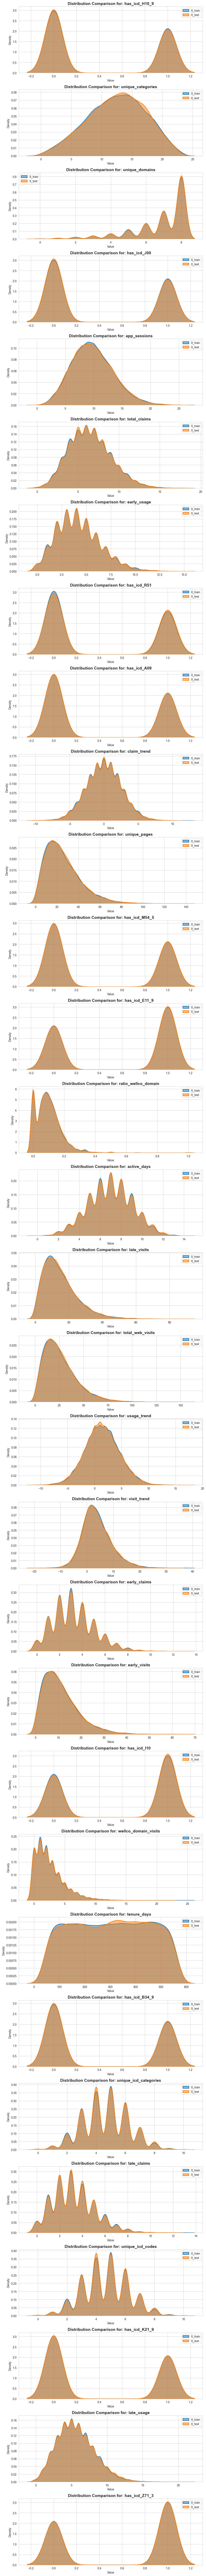


          HEALTH CHECK COMPLETE          


In [39]:
import seaborn as sns

sns.set_style("whitegrid")

def check_column_consistency(X_train, X_test):
    """Checks if X_train and X_test have the same column names and order."""
    train_cols = X_train.columns
    test_cols = X_test.columns
    
    # Check column names
    if set(train_cols) == set(test_cols):
        print("✅ Column names are consistent across both datasets.")
    else:
        print("❌ Column names are NOT consistent.")
        missing_in_test = list(set(train_cols) - set(test_cols))
        missing_in_train = list(set(test_cols) - set(train_cols))
        if missing_in_test:
            print(f"   - Columns in X_train but missing in X_test: {missing_in_test}")
        if missing_in_train:
            print(f"   - Columns in X_test but missing in X_train: {missing_in_train}")
            
    # Check column order (only necessary if names are the same, but good practice)
    common_cols = list(set(train_cols) & set(test_cols))
    train_order = list(train_cols[train_cols.isin(common_cols)])
    test_order = list(test_cols[test_cols.isin(common_cols)])
    
    if train_order == test_order:
        print("✅ Column order for common columns is the same.")
    else:
        print("⚠️ Column order is different for common columns. Be careful when using positional indexing.")

    return common_cols

def check_missing_values(X_train, X_test):
    """Checks for NaNs in both datasets and reports findings."""
    print("\n--- 2. Missing Value (NaN) Check ---")

    # Check X_train
    nan_train = X_train.isnull().sum()
    nan_train = nan_train[nan_train > 0]
    if not nan_train.empty:
        print("⚠️ NaNs found in X_train:")
        print(nan_train)
    else:
        print("✅ No NaNs found in X_train.")

    # Check X_test
    nan_test = X_test.isnull().sum()
    nan_test = nan_test[nan_test > 0]
    if not nan_test.empty:
        print("\n⚠️ NaNs found in X_test:")
        print(nan_test)
    else:
        print("\n✅ No NaNs found in X_test.")

def analyze_data_drift(X_train, X_test, common_cols):
    """Analyzes and plots data drift for common columns."""
    print("\n--- 3. Data Drift Analysis and Visualization ---")
    
    # 1. Separate column types
    numerical_cols = X_train[common_cols].select_dtypes(include=np.number).columns
    categorical_cols = X_train[common_cols].select_dtypes(include='object').columns
    
    print(f"Analyzing {len(numerical_cols)} numerical and {len(categorical_cols)} categorical features for drift.")

    # --- Numerical Feature Drift (KDE Plot) ---
    if len(numerical_cols) > 0:
        fig_num, axes_num = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(10, 4 * len(numerical_cols)))
        if len(numerical_cols) == 1:
            axes_num = [axes_num] # Ensure axes is iterable if only one subplot

        print("\n> Numerical Drift (Distribution Shift):")
        for i, col in enumerate(numerical_cols):
            ax = axes_num[i]
            
            # Plot the density of the training data
            sns.kdeplot(X_train[col].dropna(), label='X_train', ax=ax, fill=True, alpha=0.5, linewidth=2)
            # Plot the density of the test data
            sns.kdeplot(X_test[col].dropna(), label='X_test', ax=ax, fill=True, alpha=0.5, linewidth=2)
            
            # Use statistical distance (e.g., difference in means) as a simple indicator
            mean_diff = X_test[col].mean() - X_train[col].mean()
            
            ax.set_title(f'Distribution Comparison for: {col}', fontsize=14, fontweight='bold')
            ax.set_xlabel('Value')
            ax.legend()
            
            # Simple assessment of drift
            if abs(mean_diff) > X_train[col].std() * 0.2: # Drift if mean shift is > 20% of std dev
                 print(f"  ⚠️ Potential Drift in {col}: Mean shift is {mean_diff:.2f}")
            else:
                 print(f"  ✅ {col}: Mean shift is acceptable ({mean_diff:.2f})")

        fig_num.tight_layout()
        plt.show()
        # [Image of Statistical Distribution Comparison for Data Drift]

    # --- Categorical Feature Drift (Frequency Bar Plot) ---
    if len(categorical_cols) > 0:
        fig_cat, axes_cat = plt.subplots(nrows=len(categorical_cols), ncols=1, figsize=(10, 4 * len(categorical_cols)))
        if len(categorical_cols) == 1:
            axes_cat = [axes_cat] # Ensure axes is iterable

        print("\n> Categorical Drift (Frequency Shift):")
        for i, col in enumerate(categorical_cols):
            ax = axes_cat[i]
            
            # Calculate value counts and normalize to get frequencies
            train_freq = X_train[col].value_counts(normalize=True).rename('X_train').sort_index()
            test_freq = X_test[col].value_counts(normalize=True).rename('X_test').sort_index()
            
            # Combine into a single DataFrame for easy plotting
            df_freq = pd.concat([train_freq, test_freq], axis=1).fillna(0)
            df_freq.plot(kind='bar', ax=ax, alpha=0.7, rot=0)
            
            ax.set_title(f'Frequency Comparison for: {col}', fontsize=14, fontweight='bold')
            ax.set_ylabel('Proportion')
            ax.set_xlabel('Category')
            ax.legend(title='Dataset')
            
            # Simple assessment of drift using maximum absolute frequency difference
            max_freq_diff = (df_freq['X_train'] - df_freq['X_test']).abs().max()
            if max_freq_diff > 0.1: # Drift if any category shift is > 10 percentage points
                 print(f"  ⚠️ Potential Drift in {col}: Max freq difference {max_freq_diff:.2f}")
            else:
                 print(f"  ✅ {col}: Frequency shift is acceptable ({max_freq_diff:.2f})")

        fig_cat.tight_layout()
        plt.show()
        # 

def dataset_health_check(X_train, X_test):
    """Performs all required checks."""
    print("=========================================")
    print("     DATASET HEALTH CHECK STARTING     ")
    print("=========================================")

    # 1. Check Column Consistency
    print("\n--- 1. Column Consistency Check ---")
    common_cols = check_column_consistency(X_train, X_test)

    # 2. Check Missing Values
    check_missing_values(X_train, X_test)

    # 3. Analyze Data Drift (only on common columns)
    if common_cols:
        analyze_data_drift(X_train, X_test, common_cols)
    else:
        print("\n--- 3. Data Drift Analysis Skipped ---")
        print("Cannot check for drift because there are no common columns.")

def check_column_consistency(X_train, X_test):
    """Checks if X_train and X_test have the same column names and order."""
    train_cols = X_train.columns
    test_cols = X_test.columns

    # Check column names
    if set(train_cols) == set(test_cols):
        print("✅ Column names are consistent across both datasets.")
    else:
        print("❌ Column names are NOT consistent.")
        missing_in_test = list(set(train_cols) - set(test_cols))
        missing_in_train = list(set(test_cols) - set(train_cols))
        if missing_in_test:
            print(f"   - Columns in X_train but missing in X_test: {missing_in_test}")
        if missing_in_train:
            print(f"   - Columns in X_test but missing in X_train: {missing_in_train}")

    # Check column order (only necessary if names are the same, but good practice)
    common_cols = list(set(train_cols) & set(test_cols))
    train_order = list(train_cols[train_cols.isin(common_cols)])
    test_order = list(test_cols[test_cols.isin(common_cols)])

    if train_order == test_order:
        print("✅ Column order for common columns is the same.")
    else:
        print(
            "⚠️ Column order is different for common columns. Be careful when using positional indexing."
        )

    return common_cols


def check_missing_values(X_train, X_test):
    """Checks for NaNs in both datasets and reports findings."""
    print("\n--- 2. Missing Value (NaN) Check ---")

    # Check X_train
    nan_train = X_train.isnull().sum()
    nan_train = nan_train[nan_train > 0]
    if not nan_train.empty:
        print("⚠️ NaNs found in X_train:")
        print(nan_train)
    else:
        print("✅ No NaNs found in X_train.")

    # Check X_test
    nan_test = X_test.isnull().sum()
    nan_test = nan_test[nan_test > 0]
    if not nan_test.empty:
        print("\n⚠️ NaNs found in X_test:")
        print(nan_test)
    else:
        print("\n✅ No NaNs found in X_test.")


def analyze_data_drift(X_train, X_test, common_cols):
    """Analyzes and plots data drift for common columns."""
    print("\n--- 3. Data Drift Analysis and Visualization ---")

    # 1. Separate column types
    numerical_cols = X_train[common_cols].select_dtypes(include=np.number).columns
    categorical_cols = X_train[common_cols].select_dtypes(include="object").columns

    print(
        f"Analyzing {len(numerical_cols)} numerical and {len(categorical_cols)} categorical features for drift."
    )

    # --- Numerical Feature Drift (KDE Plot) ---
    if len(numerical_cols) > 0:
        fig_num, axes_num = plt.subplots(
            nrows=len(numerical_cols), ncols=1, figsize=(10, 4 * len(numerical_cols))
        )
        if len(numerical_cols) == 1:
            axes_num = [axes_num]  # Ensure axes is iterable if only one subplot

        print("\n> Numerical Drift (Distribution Shift):")
        for i, col in enumerate(numerical_cols):
            ax = axes_num[i]

            # Plot the density of the training data
            sns.kdeplot(
                X_train[col].dropna(),
                label="X_train",
                ax=ax,
                fill=True,
                alpha=0.5,
                linewidth=2,
            )
            # Plot the density of the test data
            sns.kdeplot(
                X_test[col].dropna(),
                label="X_test",
                ax=ax,
                fill=True,
                alpha=0.5,
                linewidth=2,
            )

            # Use statistical distance (e.g., difference in means) as a simple indicator
            mean_diff = X_test[col].mean() - X_train[col].mean()

            ax.set_title(
                f"Distribution Comparison for: {col}", fontsize=14, fontweight="bold"
            )
            ax.set_xlabel("Value")
            ax.legend()

            # Simple assessment of drift
            if (
                abs(mean_diff) > X_train[col].std() * 0.2
            ):  # Drift if mean shift is > 20% of std dev
                print(f"  ⚠️ Potential Drift in {col}: Mean shift is {mean_diff:.2f}")
            else:
                print(f"  ✅ {col}: Mean shift is acceptable ({mean_diff:.2f})")

        fig_num.tight_layout()
        plt.show()
        # [Image of Statistical Distribution Comparison for Data Drift]

    # --- Categorical Feature Drift (Frequency Bar Plot) ---
    if len(categorical_cols) > 0:
        fig_cat, axes_cat = plt.subplots(
            nrows=len(categorical_cols),
            ncols=1,
            figsize=(10, 4 * len(categorical_cols)),
        )
        if len(categorical_cols) == 1:
            axes_cat = [axes_cat]  # Ensure axes is iterable

        print("\n> Categorical Drift (Frequency Shift):")
        for i, col in enumerate(categorical_cols):
            ax = axes_cat[i]

            # Calculate value counts and normalize to get frequencies
            train_freq = (
                X_train[col].value_counts(normalize=True).rename("X_train").sort_index()
            )
            test_freq = (
                X_test[col].value_counts(normalize=True).rename("X_test").sort_index()
            )

            # Combine into a single DataFrame for easy plotting
            df_freq = pd.concat([train_freq, test_freq], axis=1).fillna(0)
            df_freq.plot(kind="bar", ax=ax, alpha=0.7, rot=0)

            ax.set_title(
                f"Frequency Comparison for: {col}", fontsize=14, fontweight="bold"
            )
            ax.set_ylabel("Proportion")
            ax.set_xlabel("Category")
            ax.legend(title="Dataset")

            # Simple assessment of drift using maximum absolute frequency difference
            max_freq_diff = (df_freq["X_train"] - df_freq["X_test"]).abs().max()
            if (
                max_freq_diff > 0.1
            ):  # Drift if any category shift is > 10 percentage points
                print(
                    f"  ⚠️ Potential Drift in {col}: Max freq difference {max_freq_diff:.2f}"
                )
            else:
                print(
                    f"  ✅ {col}: Frequency shift is acceptable ({max_freq_diff:.2f})"
                )

        fig_cat.tight_layout()
        plt.show()
        #


def dataset_health_check(X_train, X_test):
    """Performs all required checks."""
    print("=========================================")
    print("     DATASET HEALTH CHECK STARTING     ")
    print("=========================================")

    # 1. Check Column Consistency
    print("\n--- 1. Column Consistency Check ---")
    common_cols = check_column_consistency(X_train, X_test)

    # 2. Check Missing Values
    check_missing_values(X_train, X_test)

    # 3. Analyze Data Drift (only on common columns)
    if common_cols:
        analyze_data_drift(X_train, X_test, common_cols)
    else:
        print("\n--- 3. Data Drift Analysis Skipped ---")
        print("Cannot check for drift because there are no common columns.")


# --- Execution ---
dataset_health_check(X_train, X_test)

print("\n=========================================")
print("          HEALTH CHECK COMPLETE          ")
print("=========================================")

### feature selection

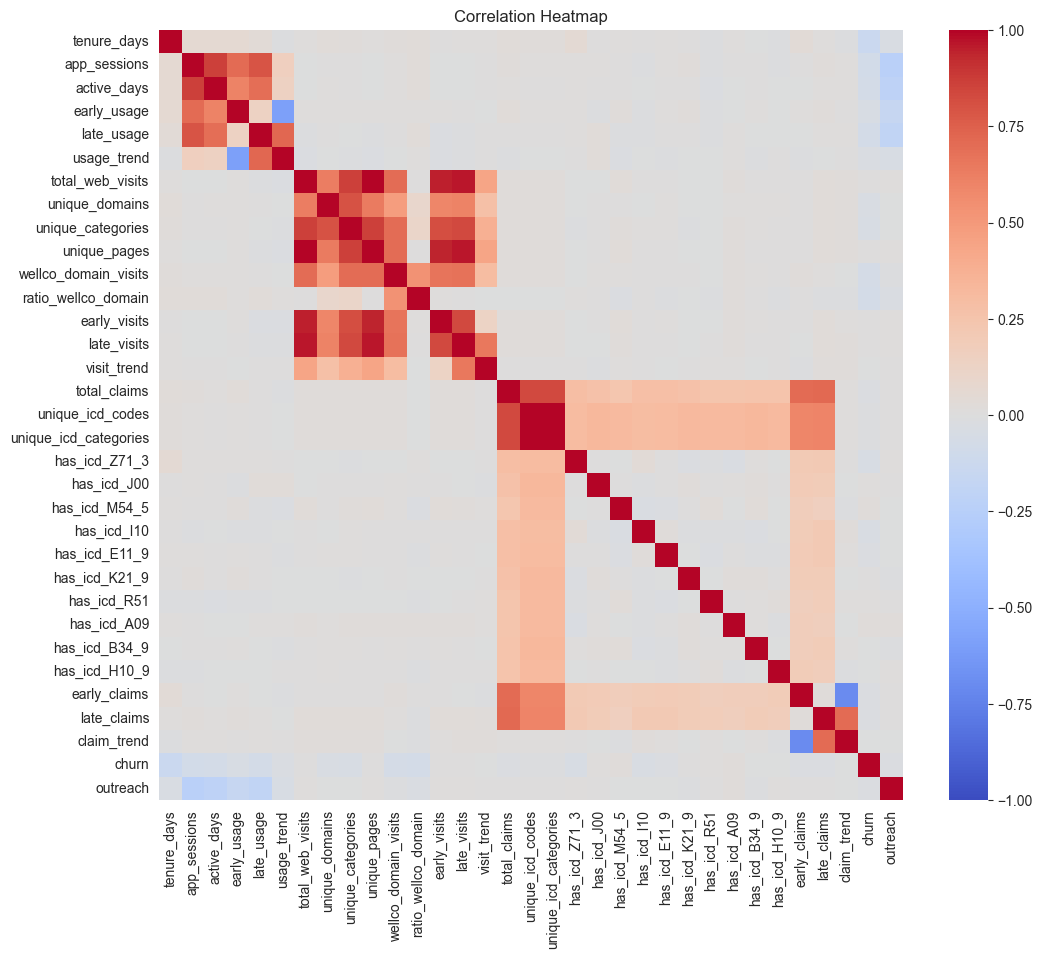

In [40]:
import seaborn as sns

import matplotlib.pyplot as plt

# Combine X_train with churn and outreach
X_train_with_labels = X_train.copy()
X_train_with_labels["churn"] = y_train
X_train_with_labels["outreach"] = treatment_train

# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

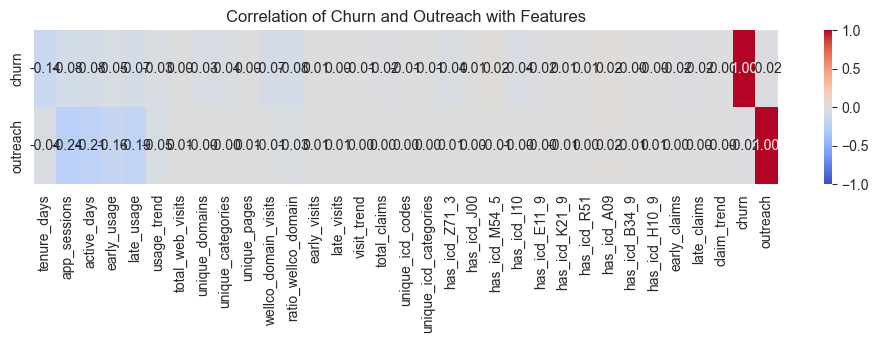

In [41]:
# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Filter the correlation matrix to show only 'churn' and 'outreach' correlations with all features
filtered_corr = corr_matrix.loc[["churn", "outreach"]]

# Display the filtered correlation matrix
plt.figure(figsize=(12, 2))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Churn and Outreach with Features")
plt.show()

In [42]:
## Correlation Analysis: Identify Redundant Features

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get correlation matrix (already computed in previous cell)
corr_abs = corr_matrix.abs()

# 1. Find highly correlated feature pairs (threshold: 0.8)
upper_triangle = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
high_corr_pairs = []

for i in range(len(corr_abs.columns)):
    for j in range(i + 1, len(corr_abs.columns)):
        if corr_abs.iloc[i, j] > 0.8:
            high_corr_pairs.append(
                {
                    "Feature_1": corr_abs.columns[i],
                    "Feature_2": corr_abs.columns[j],
                    "Correlation": corr_abs.iloc[i, j],
                }
            )

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlation", ascending=False)

print("=" * 80)
print("HIGHLY CORRELATED FEATURES (|r| > 0.8)")
print("=" * 80)
if len(high_corr_df) > 0:
    print(high_corr_df.head(20).to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr_df)}")
else:
    print("✅ No feature pairs with |correlation| > 0.8")

# 2. Check correlation with target (churn) and treatment (outreach)
target_corr = (
    corr_matrix[["churn", "outreach"]].abs().sort_values("churn", ascending=False)
)

print("\n" + "=" * 80)
print("FEATURE CORRELATION WITH CHURN & OUTREACH")
print("=" * 80)
print(target_corr.head(20).to_string())

# 3. Identify features to potentially drop
# Rule: If two features correlated > 0.8, drop the one with lower correlation to churn
features_to_drop = set()

for _, row in high_corr_df.iterrows():
    feat1, feat2 = row["Feature_1"], row["Feature_2"]

    # Skip if already marked for dropping
    if feat1 in features_to_drop or feat2 in features_to_drop:
        continue

    # Compare correlation with churn
    if feat1 in target_corr.index and feat2 in target_corr.index:
        corr1 = target_corr.loc[feat1, "churn"]
        corr2 = target_corr.loc[feat2, "churn"]

        # Drop the feature with weaker correlation to churn
        if corr1 < corr2:
            features_to_drop.add(feat1)
        else:
            features_to_drop.add(feat2)

print("\n" + "=" * 80)
print("RECOMMENDED FEATURES TO DROP (Redundant + Weak Churn Correlation)")
print("=" * 80)
if len(features_to_drop) > 0:
    print(f"Total features to drop: {len(features_to_drop)}")
    print(sorted(features_to_drop))
else:
    print("✅ No redundant features detected")

# 4. Variance Inflation Factor (VIF) check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric features (exclude target/treatment if still present)
numeric_cols = [
    col
    for col in X_train.columns
    if col not in ["churn", "outreach"] and X_train[col].dtype in ["float64", "int64"]
]

# Sample if too many features (VIF is slow)
if len(numeric_cols) > 50:
    print(
        f"\n⚠️  Sampling 50 features for VIF analysis (full dataset has {len(numeric_cols)} features)"
    )
    numeric_cols_sample = np.random.choice(numeric_cols, 50, replace=False).tolist()
else:
    numeric_cols_sample = numeric_cols

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols_sample
vif_data["VIF"] = [
    variance_inflation_factor(X_train[numeric_cols_sample].fillna(0).values, i)
    for i in range(len(numeric_cols_sample))
]
vif_data = vif_data.sort_values("VIF", ascending=False)

print("\n" + "=" * 80)
print("VARIANCE INFLATION FACTOR (VIF) - Top 20 Features")
print("VIF > 10 indicates severe multicollinearity")
print("=" * 80)
print(vif_data.head(20).to_string(index=False))

# 5. PCA Recommendation
print("\n" + "=" * 80)
print("PCA vs FEATURE SELECTION RECOMMENDATION")
print("=" * 80)

n_features = X_train.shape[1]
n_high_corr = len(high_corr_df)
n_vif_high = (vif_data["VIF"] > 10).sum()

print(f"\n📊 DATASET SUMMARY:")
print(f"   Total features: {n_features}")
print(f"   Highly correlated pairs: {n_high_corr}")
print(f"   Features with VIF > 10: {n_vif_high}")
print(f"   Recommended to drop: {len(features_to_drop)}")

print(f"\n💡 RECOMMENDATION:")

if n_high_corr > 20 or n_vif_high > 10:
    print("   ⚠️  HIGH MULTICOLLINEARITY DETECTED")
    print("   → Option 1: Drop redundant features (simple, interpretable)")
    print(
        "   → Option 2: Use PCA (loses interpretability, may help with regularization)"
    )
    print("\n   For WellCo uplift modeling (per data/wellco_client_brief.txt):")
    print("   ✅ RECOMMENDED: Drop redundant features")
    print("      - Preserves clinical interpretability (ICD-10 codes, claims_count)")
    print("      - LightGBM handles remaining collinearity well")
    print("   ❌ AVOID PCA for now:")
    print("      - Loses domain meaning (can't explain 'PC1' to clinicians)")
    print("      - Use only if dimensionality reduction is critical for compute")
else:
    print("   ✅ MODERATE MULTICOLLINEARITY")
    print(
        "   → Drop {0} redundant features (correlation > 0.8)".format(
            len(features_to_drop)
        )
    )
    print("   → PCA not needed — LightGBM handles remaining correlations")

# 6. Save features to drop for reproducibility
if len(features_to_drop) > 0:
    output_path = repo_root / "outputs" / f"features_to_drop_{timestamp}.txt"
    with open(output_path, "w") as f:
        f.write("\n".join(sorted(features_to_drop)))
    print(f"\n✅ Redundant features list saved to: {output_path}")

HIGHLY CORRELATED FEATURES (|r| > 0.8)
        Feature_1             Feature_2  Correlation
 unique_icd_codes unique_icd_categories     1.000000
 total_web_visits          unique_pages     0.999009
 total_web_visits           late_visits     0.968457
     unique_pages           late_visits     0.967300
 total_web_visits          early_visits     0.945446
     unique_pages          early_visits     0.944767
     app_sessions           active_days     0.863722
unique_categories          unique_pages     0.863531
 total_web_visits     unique_categories     0.859399
     early_visits           late_visits     0.834445
unique_categories           late_visits     0.831394
     total_claims      unique_icd_codes     0.829811
     total_claims unique_icd_categories     0.829811
unique_categories          early_visits     0.813687
   unique_domains     unique_categories     0.802554

Total pairs: 15

FEATURE CORRELATION WITH CHURN & OUTREACH
                         churn  outreach
churn       

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. 


VARIANCE INFLATION FACTOR (VIF) - Top 20 Features
VIF > 10 indicates severe multicollinearity
              Feature  VIF
         total_claims  inf
     unique_icd_codes  inf
          late_claims  inf
         early_claims  inf
        has_icd_H10_9  inf
        has_icd_B34_9  inf
          has_icd_A09  inf
          has_icd_R51  inf
        has_icd_K21_9  inf
        has_icd_E11_9  inf
          has_icd_I10  inf
        has_icd_M54_5  inf
          has_icd_J00  inf
        has_icd_Z71_3  inf
unique_icd_categories  inf
          claim_trend  inf
         app_sessions  inf
          visit_trend  inf
          late_visits  inf
         early_visits  inf

PCA vs FEATURE SELECTION RECOMMENDATION

📊 DATASET SUMMARY:
   Total features: 31
   Highly correlated pairs: 15
   Features with VIF > 10: 28
   Recommended to drop: 8

💡 RECOMMENDATION:
   ⚠️  HIGH MULTICOLLINEARITY DETECTED
   → Option 1: Drop redundant features (simple, interpretable)
   → Option 2: Use PCA (loses interpretability,

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [43]:
## Drop Redundant Features (If Recommended Above)

if len(features_to_drop) > 0:
    print(f"Dropping {len(features_to_drop)} redundant features...")
    X_train_reduced = X_train.drop(columns=list(features_to_drop))
    X_test_reduced = X_test.drop(columns=list(features_to_drop))

    print(f"Original shape: {X_train.shape}")
    print(f"Reduced shape:  {X_train_reduced.shape}")

    # Use X_train_reduced for modeling
else:
    print("No features to drop — proceed with current feature set")
    X_train_reduced = X_train.copy()
    X_test_reduced = X_test.copy()

Dropping 8 redundant features...
Original shape: (10000, 31)
Reduced shape:  (10000, 23)


In [44]:
train_data_outreach_grouped = X_train_reduced.groupby(treatment_train).mean()
train_data_outreach_grouped

,tenure_days,app_sessions,early_usage,late_usage,usage_trend,unique_categories,wellco_domain_visits,ratio_wellco_domain,visit_trend,total_claims,...,has_icd_I10,has_icd_E11_9,has_icd_K21_9,has_icd_R51,has_icd_A09,has_icd_B34_9,has_icd_H10_9,early_claims,late_claims,claim_trend
treatment,,,,,,,,,,,,,,,,,,,,,
0,307.287733,10.480386,4.479222,6.001164,1.521941,12.460771,2.553524,0.098863,3.790725,6.448637,...,0.589761,0.589761,0.410239,0.404255,0.406250,0.423537,0.412234,3.226895,3.221742,-0.005153
1,295.533133,8.719629,3.745733,4.973896,1.228163,12.451305,2.488956,0.094349,3.815010,6.471135,...,0.587098,0.585341,0.400100,0.404367,0.425452,0.415161,0.421436,3.244729,3.226406,-0.018323


In [45]:
train_data_outreach_grouped = X_train.groupby(treatment_train).mean()
train_data_outreach_grouped

,tenure_days,app_sessions,active_days,early_usage,late_usage,usage_trend,total_web_visits,unique_domains,unique_categories,unique_pages,...,has_icd_I10,has_icd_E11_9,has_icd_K21_9,has_icd_R51,has_icd_A09,has_icd_B34_9,has_icd_H10_9,early_claims,late_claims,claim_trend
treatment,,,,,,,,,,,,,,,,,,,,,
0,307.287733,10.480386,7.321809,4.479222,6.001164,1.521941,25.772773,6.858544,12.460771,25.241689,...,0.589761,0.589761,0.410239,0.404255,0.406250,0.423537,0.412234,3.226895,3.221742,-0.005153
1,295.533133,8.719629,6.430221,3.745733,4.973896,1.228163,26.177460,6.853665,12.451305,25.650853,...,0.587098,0.585341,0.400100,0.404367,0.425452,0.415161,0.421436,3.244729,3.226406,-0.018323



TREATMENT EFFECT BY TENURE_DAYS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low tenure_days -0.008696     3343       1422       1921       0.265120       0.273816
Medium tenure_days -0.007059     3339       1274       2065       0.181319       0.188378
  High tenure_days -0.035934     3318       1288       2030       0.128106       0.164039

Overall ATE (reference): -0.0134


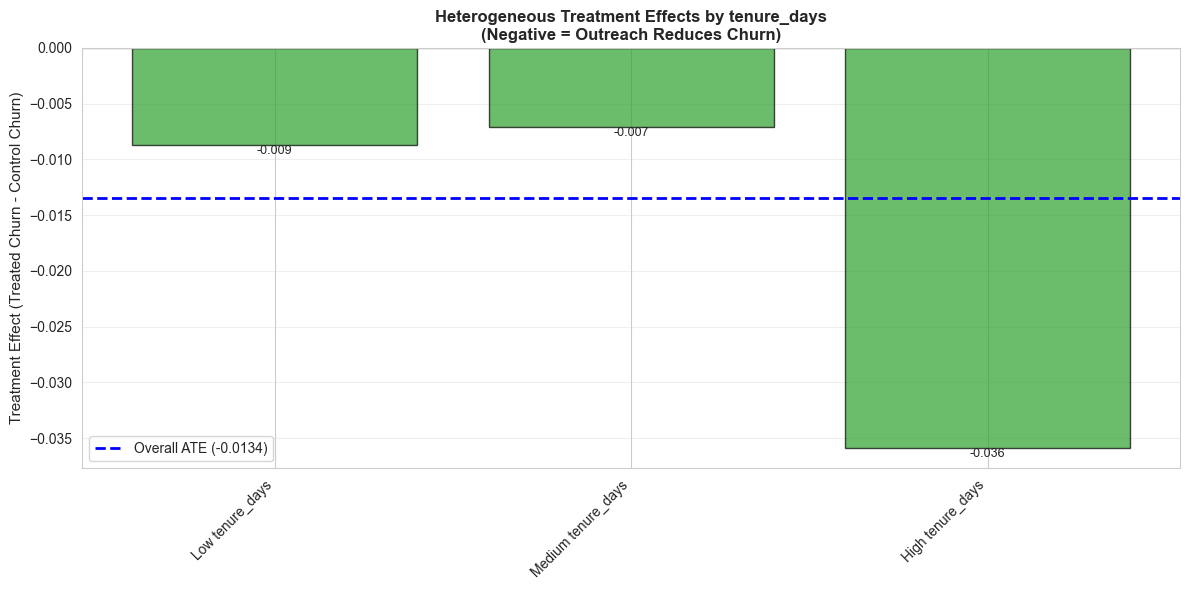


💡 CLINICAL INSIGHT for tenure_days:
   ✅ BEST: High tenure_days shows strongest benefit (ATE=-0.0359)
      → Prioritize outreach for this segment (3318 members)

TREATMENT EFFECT BY APP_SESSIONS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low app_sessions -0.027522     3840       1994       1846       0.221665       0.249187
Medium app_sessions -0.015882     3167       1220       1947       0.184426       0.200308
  High app_sessions -0.041375     2993        770       2223       0.137662       0.179037

Overall ATE (reference): -0.0134


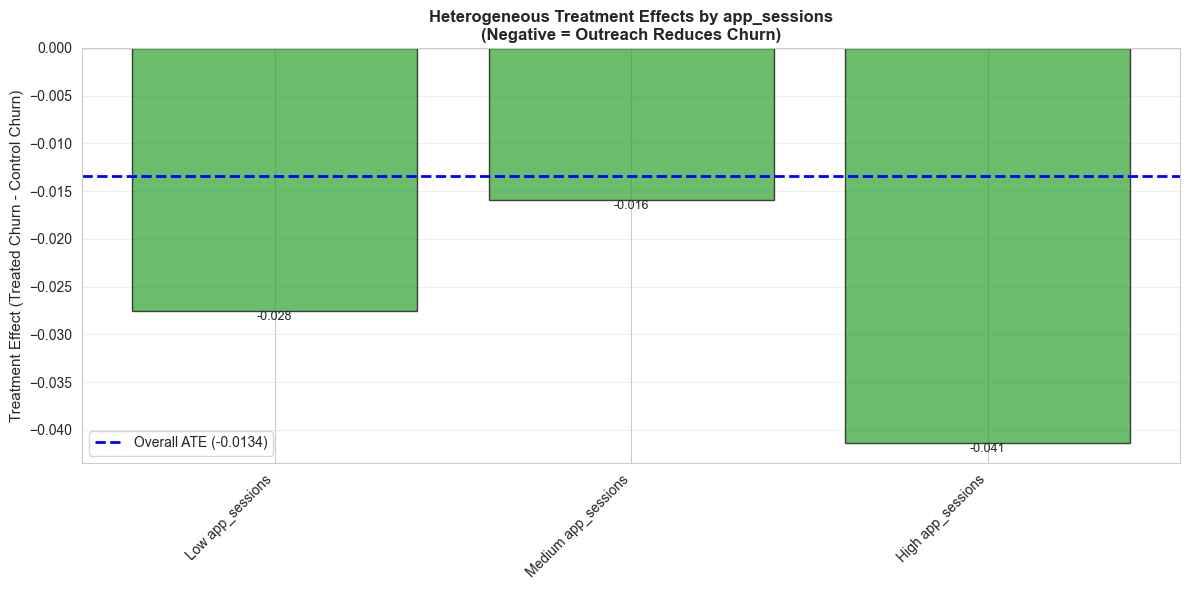


💡 CLINICAL INSIGHT for app_sessions:
   ✅ BEST: High app_sessions shows strongest benefit (ATE=-0.0414)
      → Prioritize outreach for this segment (2993 members)

TREATMENT EFFECT BY ACTIVE_DAYS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low active_days -0.021977     4114       2064       2050       0.218023       0.240000
Medium active_days -0.024217     3538       1299       2239       0.181678       0.205895
  High active_days -0.030720     2348        621       1727       0.140097       0.170816

Overall ATE (reference): -0.0134


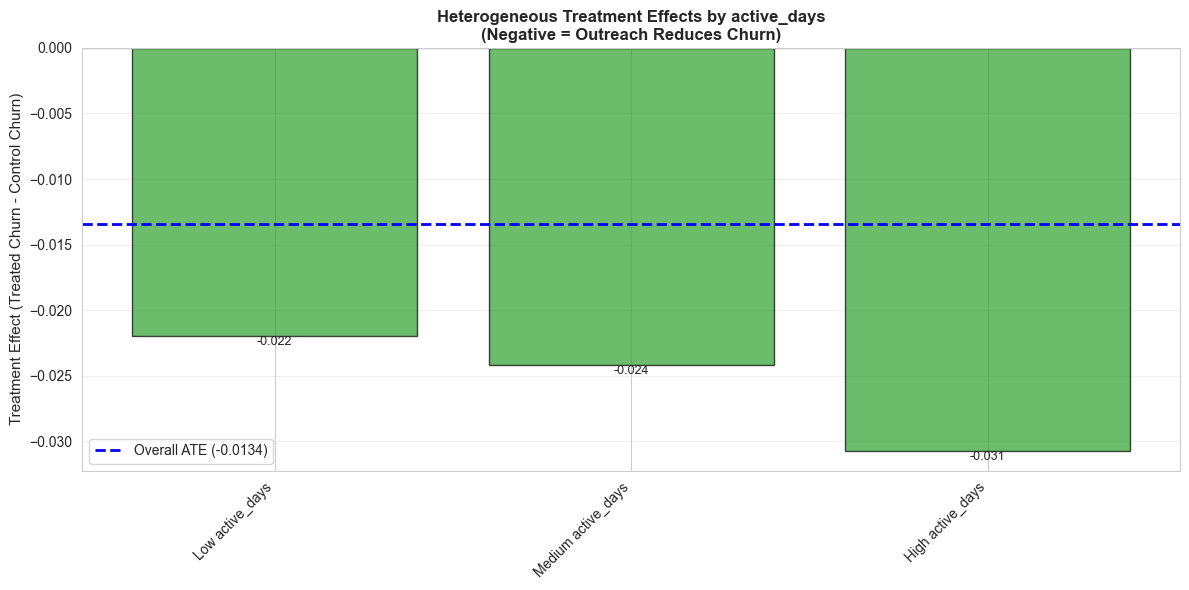


💡 CLINICAL INSIGHT for active_days:
   ✅ BEST: High active_days shows strongest benefit (ATE=-0.0307)
      → Prioritize outreach for this segment (2348 members)

TREATMENT EFFECT BY EARLY_USAGE LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_usage -0.016082     4141       1971       2170       0.211568       0.227650
Medium early_usage -0.020361     3293       1236       2057       0.182848       0.203209
  High early_usage -0.020504     2566        777       1789       0.167310       0.187814

Overall ATE (reference): -0.0134


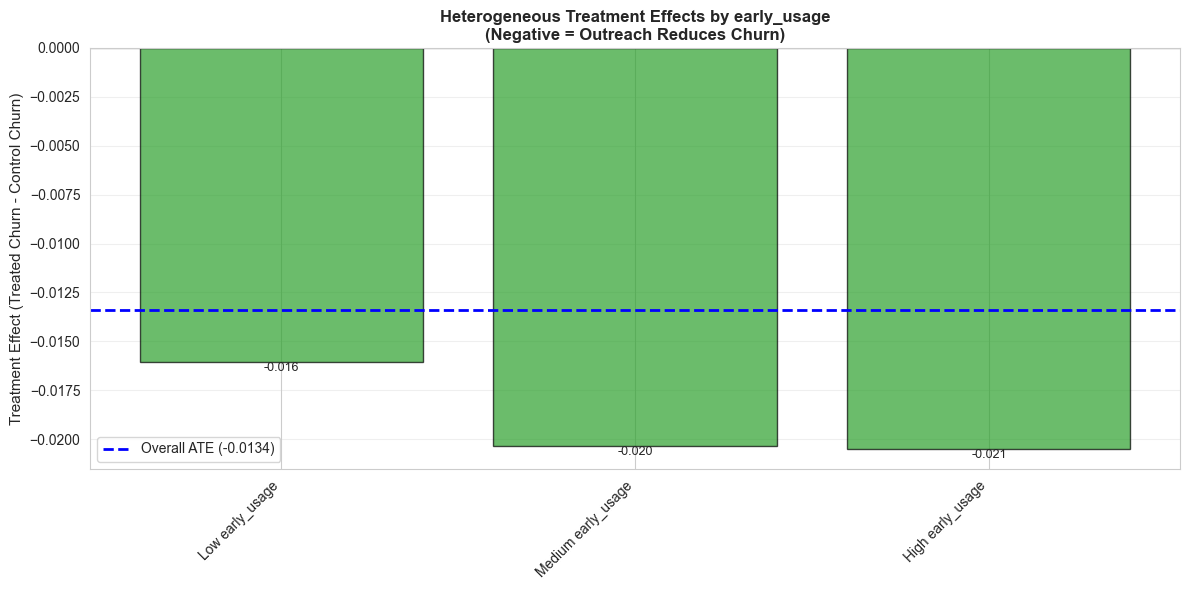


💡 CLINICAL INSIGHT for early_usage:
   ✅ BEST: High early_usage shows strongest benefit (ATE=-0.0205)
      → Prioritize outreach for this segment (2566 members)

TREATMENT EFFECT BY LATE_USAGE LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_usage -0.011727     3649       1845       1804       0.223306       0.235033
Medium late_usage -0.037844     4152       1545       2607       0.177346       0.215190
  High late_usage -0.017398     2199        594       1605       0.146465       0.163863

Overall ATE (reference): -0.0134


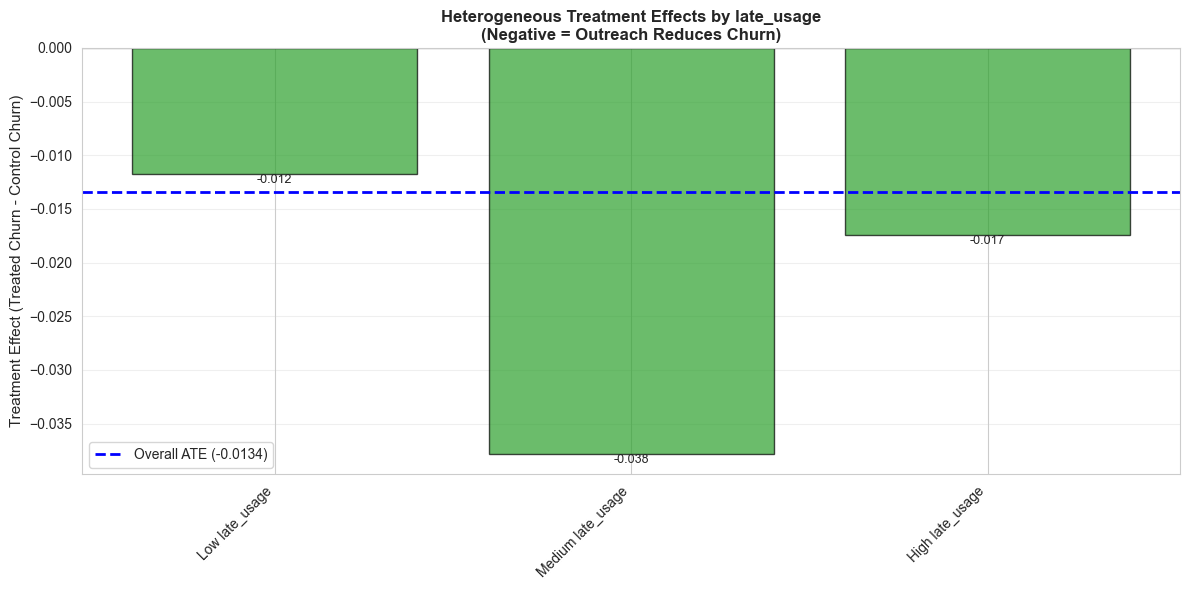


💡 CLINICAL INSIGHT for late_usage:
   ✅ BEST: Medium late_usage shows strongest benefit (ATE=-0.0378)
      → Prioritize outreach for this segment (4152 members)

TREATMENT EFFECT BY USAGE_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low usage_trend -0.013870     3938       1668       2270       0.206835       0.220705
Medium usage_trend -0.011074     3627       1451       2176       0.194349       0.205423
  High usage_trend -0.022297     2435        865       1570       0.168786       0.191083

Overall ATE (reference): -0.0134


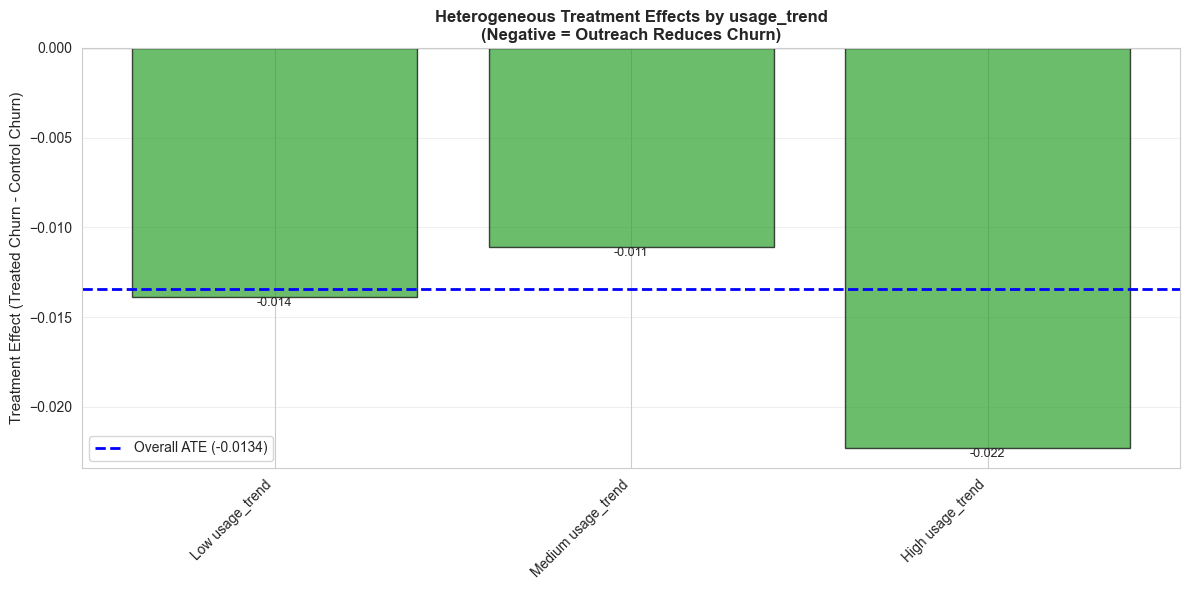


💡 CLINICAL INSIGHT for usage_trend:
   ✅ BEST: High usage_trend shows strongest benefit (ATE=-0.0223)
      → Prioritize outreach for this segment (2435 members)

TREATMENT EFFECT BY TOTAL_WEB_VISITS LEVEL
                Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low total_web_visits -0.034661     3413       1355       2058       0.183026       0.217687
Medium total_web_visits  0.002331     3346       1322       2024       0.200454       0.198123
  High total_web_visits -0.007379     3241       1307       1934       0.198929       0.206308

Overall ATE (reference): -0.0134


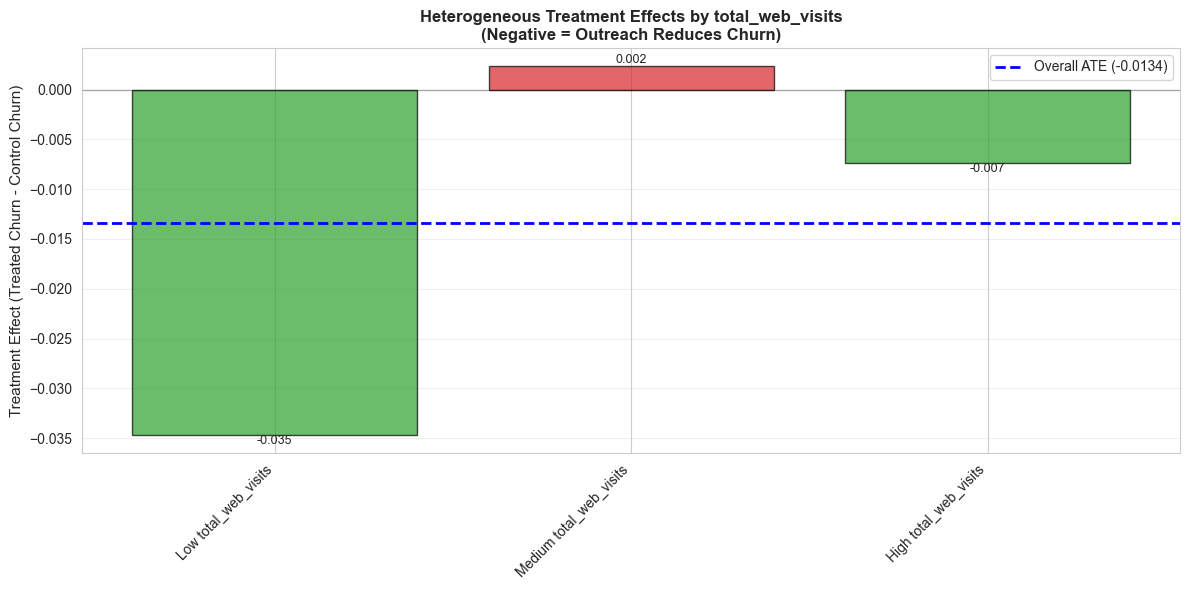


💡 CLINICAL INSIGHT for total_web_visits:
   ✅ BEST: Low total_web_visits shows strongest benefit (ATE=-0.0347)
      → Prioritize outreach for this segment (3413 members)
   ⚠️  WORST: Medium total_web_visits shows harm/no benefit (ATE=0.0023)
      → Avoid outreach for this segment (3346 members)

❌ Error processing 'unique_domains': Bin labels must be one fewer than the number of bin edges

TREATMENT EFFECT BY UNIQUE_CATEGORIES LEVEL
                 Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_categories -0.028932     3409       1363       2046       0.203228       0.232160
Medium unique_categories -0.002866     3750       1498       2252       0.208945       0.211812
  High unique_categories -0.009337     2841       1123       1718       0.162956       0.172293

Overall ATE (reference): -0.0134


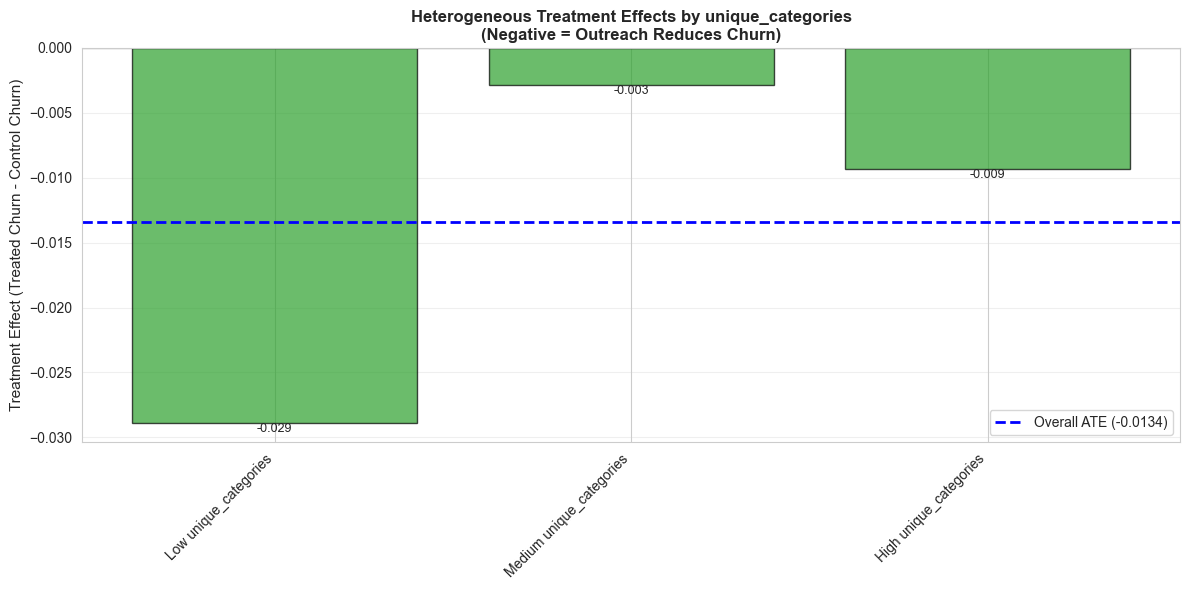


💡 CLINICAL INSIGHT for unique_categories:
   ✅ BEST: Low unique_categories shows strongest benefit (ATE=-0.0289)
      → Prioritize outreach for this segment (3409 members)

TREATMENT EFFECT BY UNIQUE_PAGES LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_pages -0.036706     3453       1365       2088       0.181685       0.218391
Medium unique_pages  0.007379     3239       1283       1956       0.204209       0.196830
  High unique_pages -0.009533     3308       1336       1972       0.196856       0.206389

Overall ATE (reference): -0.0134


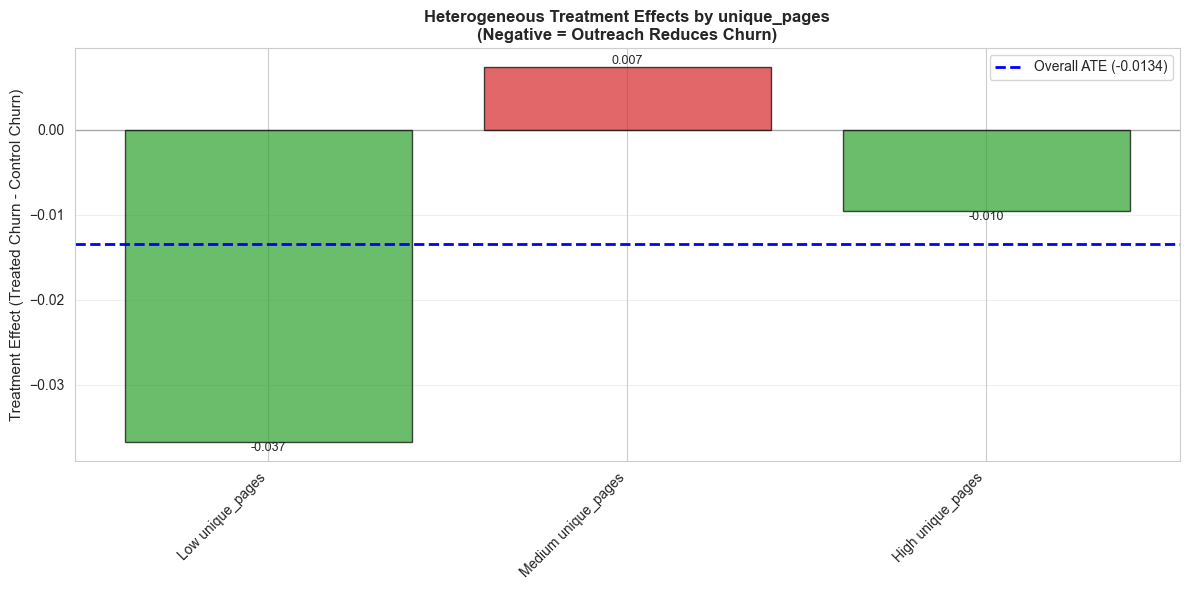


💡 CLINICAL INSIGHT for unique_pages:
   ✅ BEST: Low unique_pages shows strongest benefit (ATE=-0.0367)
      → Prioritize outreach for this segment (3453 members)
   ⚠️  WORST: Medium unique_pages shows harm/no benefit (ATE=0.0074)
      → Avoid outreach for this segment (3239 members)

TREATMENT EFFECT BY WELLCO_DOMAIN_VISITS LEVEL
                    Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low wellco_domain_visits -0.023597     4076       1646       2430       0.213852       0.237449
Medium wellco_domain_visits -0.025144     3276       1331       1945       0.192337       0.217481
  High wellco_domain_visits  0.012726     2648       1007       1641       0.163853       0.151127

Overall ATE (reference): -0.0134


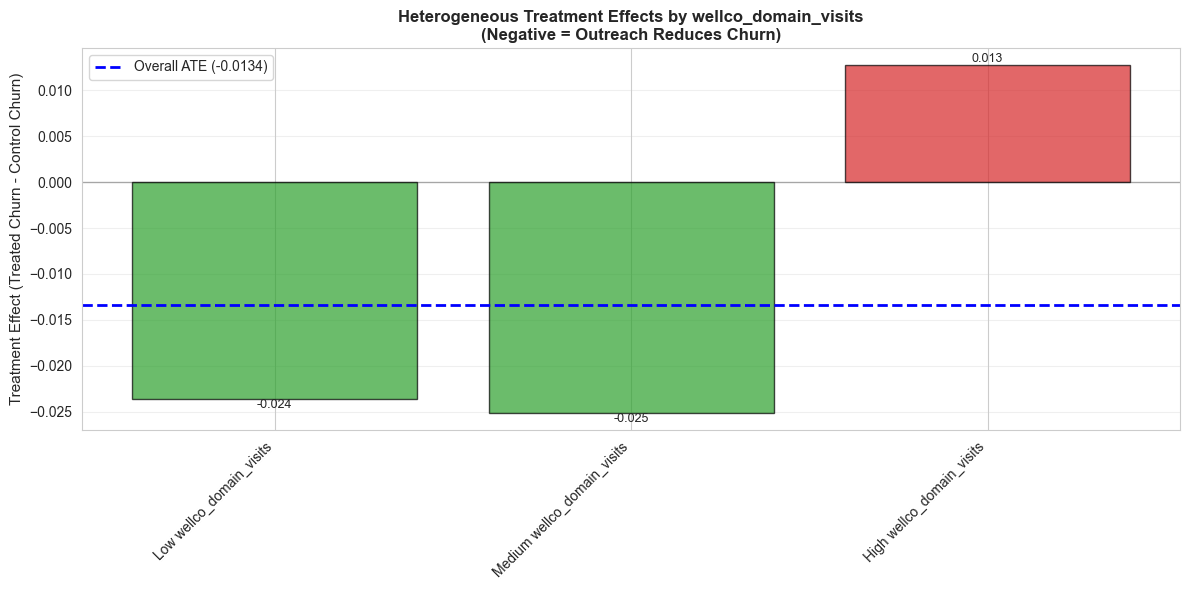


💡 CLINICAL INSIGHT for wellco_domain_visits:
   ✅ BEST: Medium wellco_domain_visits shows strongest benefit (ATE=-0.0251)
      → Prioritize outreach for this segment (3276 members)
   ⚠️  WORST: High wellco_domain_visits shows harm/no benefit (ATE=0.0127)
      → Avoid outreach for this segment (2648 members)

TREATMENT EFFECT BY RATIO_WELLCO_DOMAIN LEVEL
                   Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low ratio_wellco_domain -0.030868     3389       1393       1996       0.231156       0.262024
Medium ratio_wellco_domain -0.023959     3318       1313       2005       0.182026       0.205985
  High ratio_wellco_domain  0.011045     3293       1278       2015       0.165884       0.154839

Overall ATE (reference): -0.0134


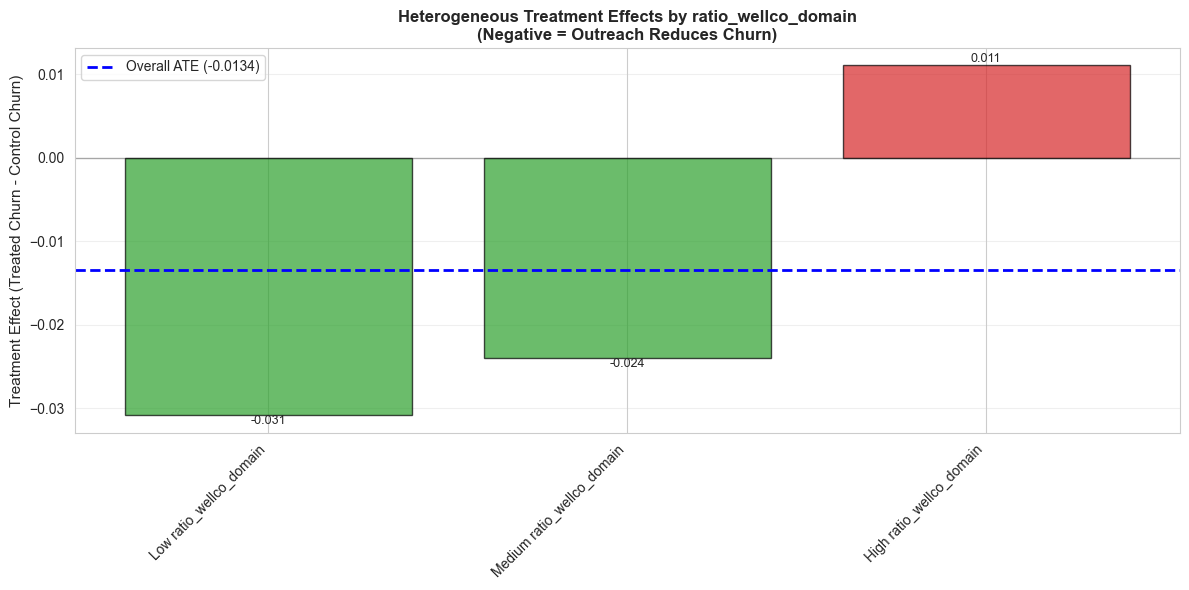


💡 CLINICAL INSIGHT for ratio_wellco_domain:
   ✅ BEST: Low ratio_wellco_domain shows strongest benefit (ATE=-0.0309)
      → Prioritize outreach for this segment (3389 members)
   ⚠️  WORST: High ratio_wellco_domain shows harm/no benefit (ATE=0.0110)
      → Avoid outreach for this segment (3293 members)

TREATMENT EFFECT BY EARLY_VISITS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_visits -0.034328     3827       1499       2328       0.183456       0.217784
Medium early_visits  0.002279     3111       1249       1862       0.196157       0.193878
  High early_visits -0.003413     3062       1236       1826       0.204693       0.208105

Overall ATE (reference): -0.0134


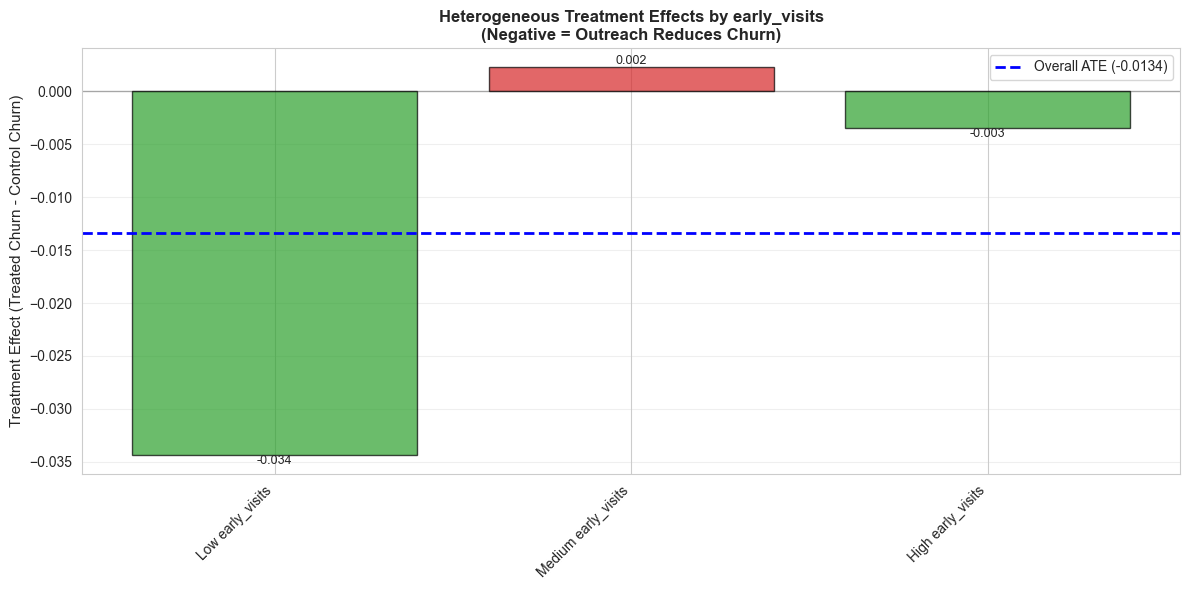


💡 CLINICAL INSIGHT for early_visits:
   ✅ BEST: Low early_visits shows strongest benefit (ATE=-0.0343)
      → Prioritize outreach for this segment (3827 members)
   ⚠️  WORST: Medium early_visits shows harm/no benefit (ATE=0.0023)
      → Avoid outreach for this segment (3111 members)

TREATMENT EFFECT BY LATE_VISITS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_visits -0.021456     3514       1397       2117       0.189692       0.211148
Medium late_visits -0.023537     3239       1266       1973       0.183254       0.206792
  High late_visits  0.004883     3247       1321       1926       0.208933       0.204050

Overall ATE (reference): -0.0134


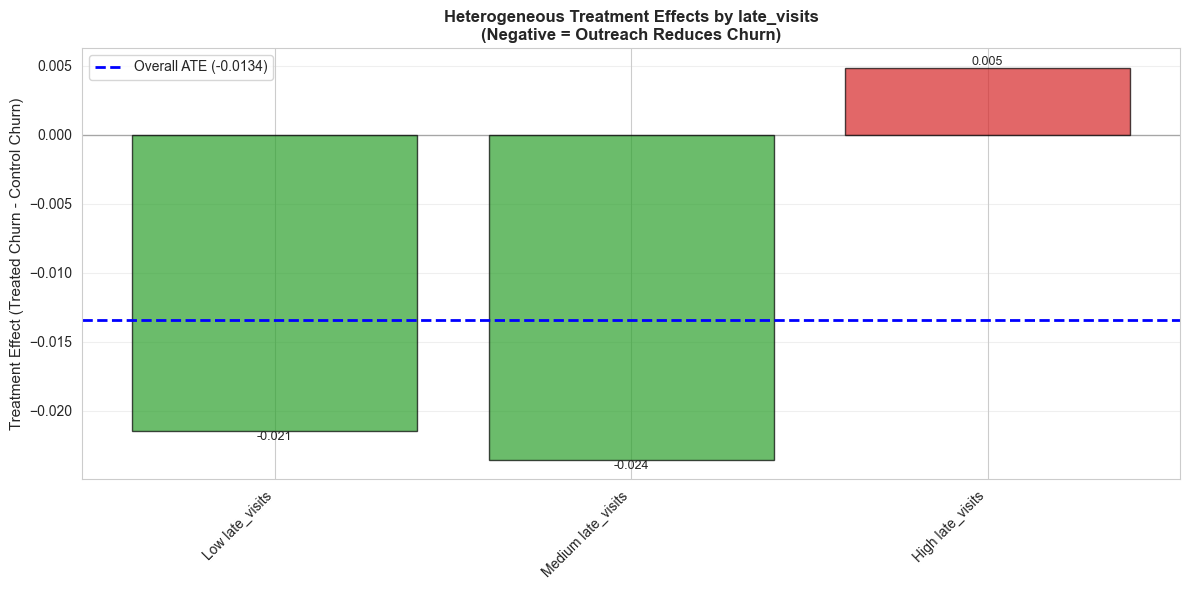


💡 CLINICAL INSIGHT for late_visits:
   ✅ BEST: Medium late_visits shows strongest benefit (ATE=-0.0235)
      → Prioritize outreach for this segment (3239 members)
   ⚠️  WORST: High late_visits shows harm/no benefit (ATE=0.0049)
      → Avoid outreach for this segment (3247 members)

TREATMENT EFFECT BY VISIT_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low visit_trend -0.010523     3657       1465       2192       0.193857       0.204380
Medium visit_trend -0.020475     3105       1214       1891       0.196870       0.217345
  High visit_trend -0.009671     3238       1305       1933       0.191571       0.201242

Overall ATE (reference): -0.0134


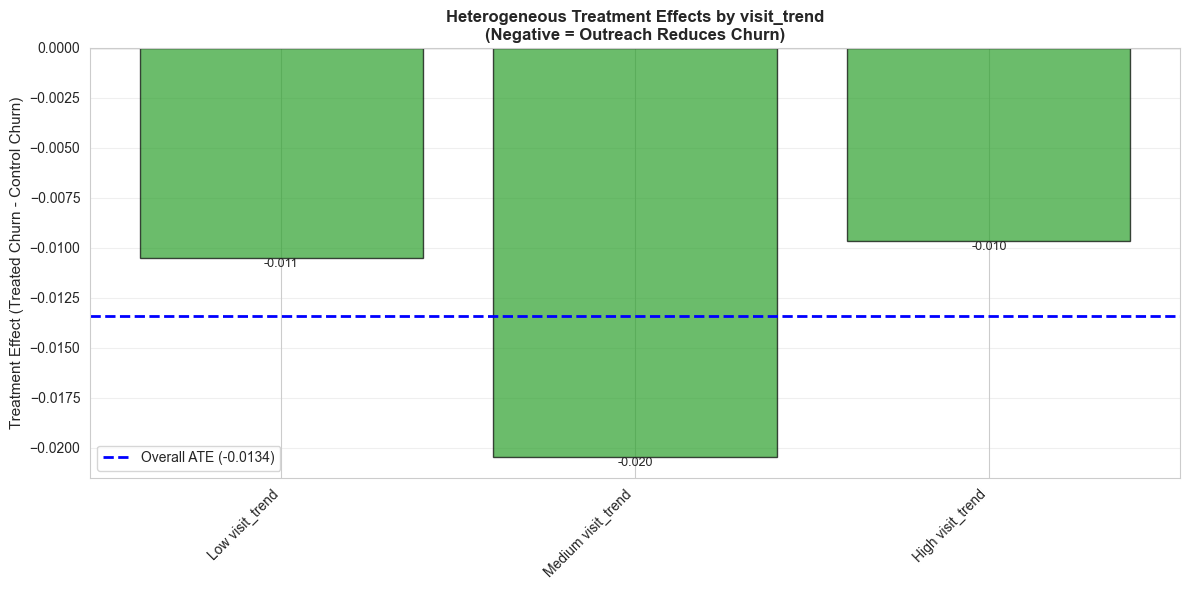


💡 CLINICAL INSIGHT for visit_trend:
   ✅ BEST: Medium visit_trend shows strongest benefit (ATE=-0.0205)
      → Prioritize outreach for this segment (3105 members)

TREATMENT EFFECT BY TOTAL_CLAIMS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low total_claims -0.026463     3798       1514       2284       0.196830       0.223292
Medium total_claims -0.012966     2979       1197       1782       0.192982       0.205948
  High total_claims  0.001417     3223       1273       1950       0.191673       0.190256

Overall ATE (reference): -0.0134


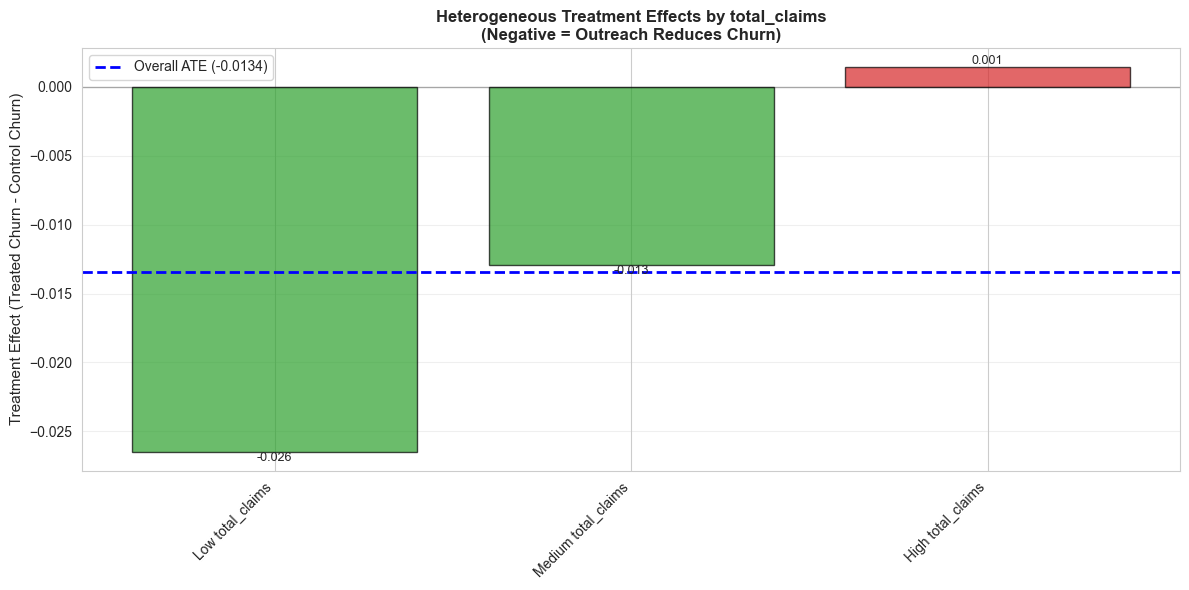


💡 CLINICAL INSIGHT for total_claims:
   ✅ BEST: Low total_claims shows strongest benefit (ATE=-0.0265)
      → Prioritize outreach for this segment (3798 members)
   ⚠️  WORST: High total_claims shows harm/no benefit (ATE=0.0014)
      → Avoid outreach for this segment (3223 members)

TREATMENT EFFECT BY UNIQUE_ICD_CODES LEVEL
                Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_icd_codes -0.024622     4613       1865       2748       0.195174       0.219796
Medium unique_icd_codes -0.016731     2431        951       1480       0.191377       0.208108
  High unique_icd_codes  0.006430     2956       1168       1788       0.194349       0.187919

Overall ATE (reference): -0.0134


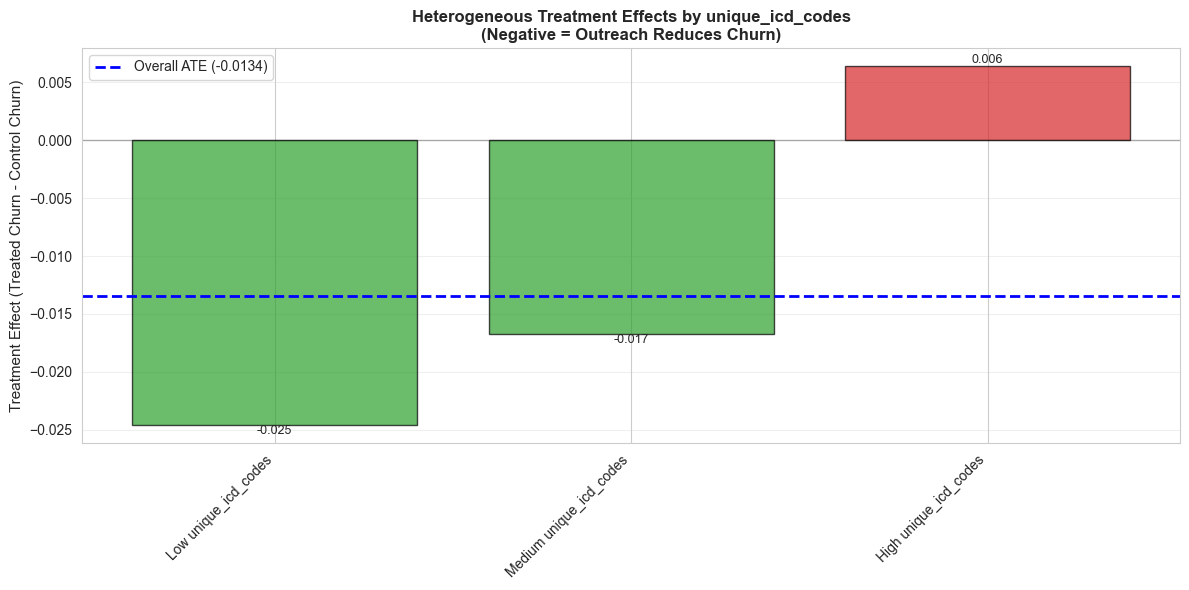


💡 CLINICAL INSIGHT for unique_icd_codes:
   ✅ BEST: Low unique_icd_codes shows strongest benefit (ATE=-0.0246)
      → Prioritize outreach for this segment (4613 members)
   ⚠️  WORST: High unique_icd_codes shows harm/no benefit (ATE=0.0064)
      → Avoid outreach for this segment (2956 members)

TREATMENT EFFECT BY UNIQUE_ICD_CATEGORIES LEVEL
                     Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_icd_categories -0.024622     4613       1865       2748       0.195174       0.219796
Medium unique_icd_categories -0.016731     2431        951       1480       0.191377       0.208108
  High unique_icd_categories  0.006430     2956       1168       1788       0.194349       0.187919

Overall ATE (reference): -0.0134


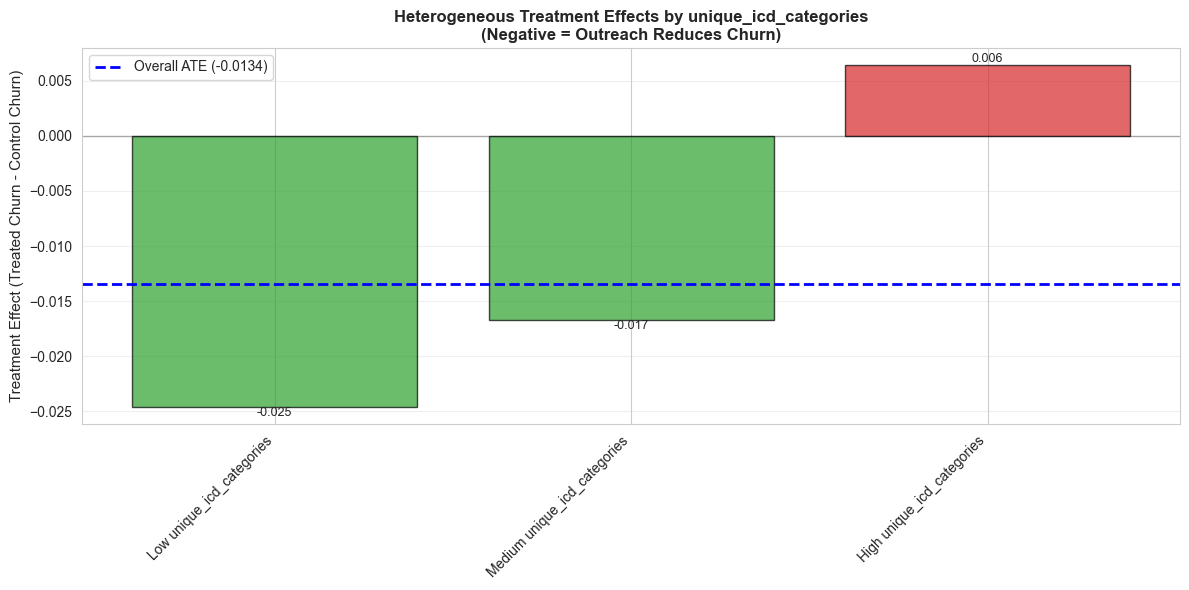


💡 CLINICAL INSIGHT for unique_icd_categories:
   ✅ BEST: Low unique_icd_categories shows strongest benefit (ATE=-0.0246)
      → Prioritize outreach for this segment (4613 members)
   ⚠️  WORST: High unique_icd_categories shows harm/no benefit (ATE=0.0064)
      → Avoid outreach for this segment (2956 members)

TREATMENT EFFECT BY HAS_ICD_Z71_3 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_Z71_3 -0.012038     4104       1610       2494       0.214907       0.226945
1.0 has_icd_Z71_3 -0.013775     5896       2374       3522       0.179865       0.193640

Overall ATE (reference): -0.0134


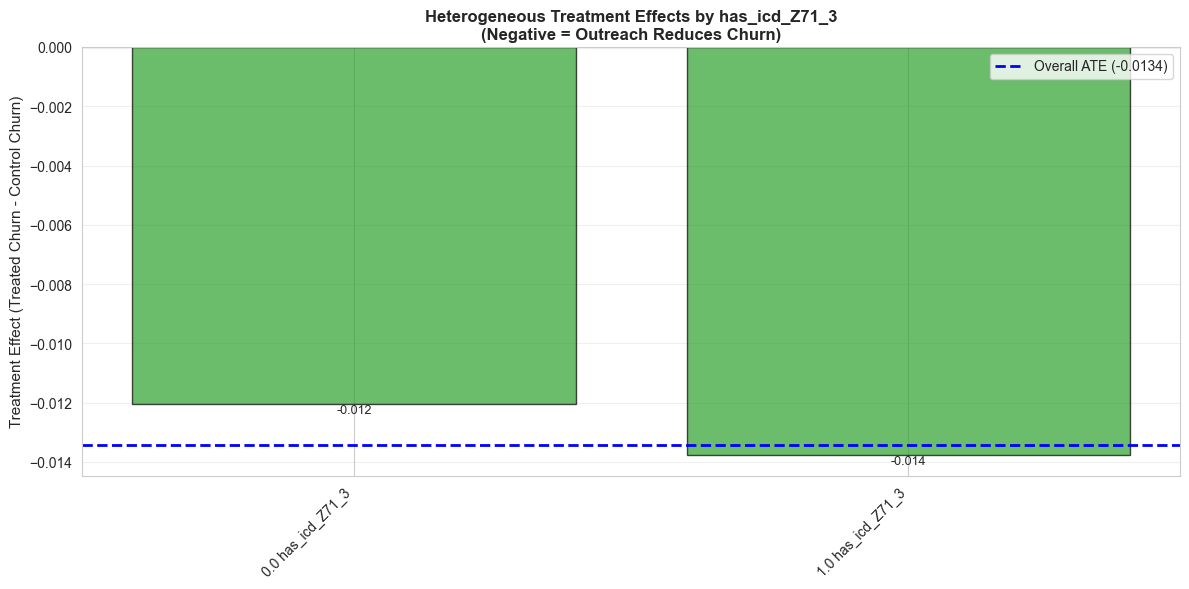


💡 CLINICAL INSIGHT for has_icd_Z71_3:
   ✅ BEST: 1.0 has_icd_Z71_3 shows strongest benefit (ATE=-0.0138)
      → Prioritize outreach for this segment (5896 members)

TREATMENT EFFECT BY HAS_ICD_J00 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_J00 -0.008700     5892       2336       3556       0.193493       0.202193
1.0 has_icd_J00 -0.020259     4108       1648       2460       0.194782       0.215041

Overall ATE (reference): -0.0134


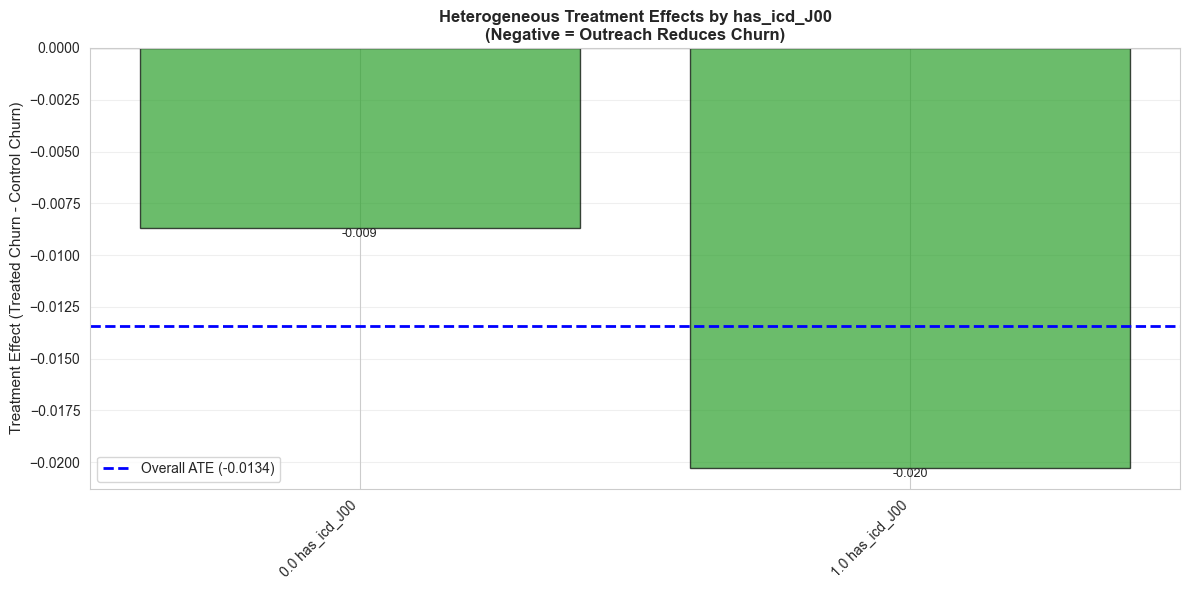


💡 CLINICAL INSIGHT for has_icd_J00:
   ✅ BEST: 1.0 has_icd_J00 shows strongest benefit (ATE=-0.0203)
      → Prioritize outreach for this segment (4108 members)

TREATMENT EFFECT BY HAS_ICD_M54_5 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_M54_5 -0.009877     5846       2347       3499       0.188752       0.198628
1.0 has_icd_M54_5 -0.018118     4154       1637       2517       0.201588       0.219706

Overall ATE (reference): -0.0134


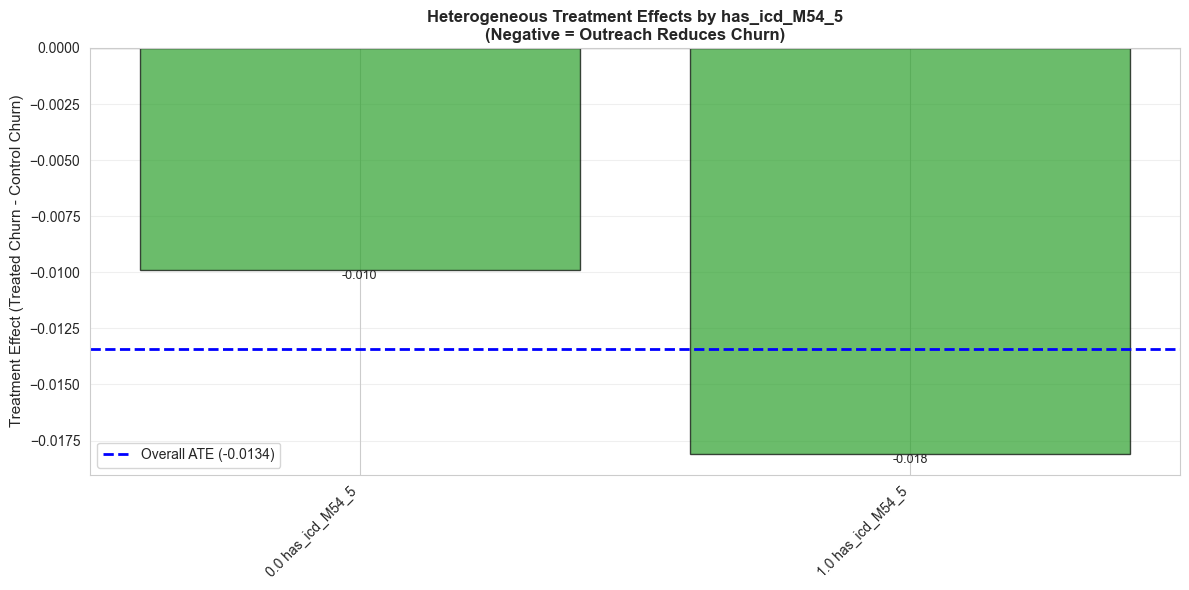


💡 CLINICAL INSIGHT for has_icd_M54_5:
   ✅ BEST: 1.0 has_icd_M54_5 shows strongest benefit (ATE=-0.0181)
      → Prioritize outreach for this segment (4154 members)

TREATMENT EFFECT BY HAS_ICD_I10 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_I10 -0.030551     4113       1645       2468       0.202432       0.232982
1.0 has_icd_I10 -0.001570     5887       2339       3548       0.188115       0.189684

Overall ATE (reference): -0.0134


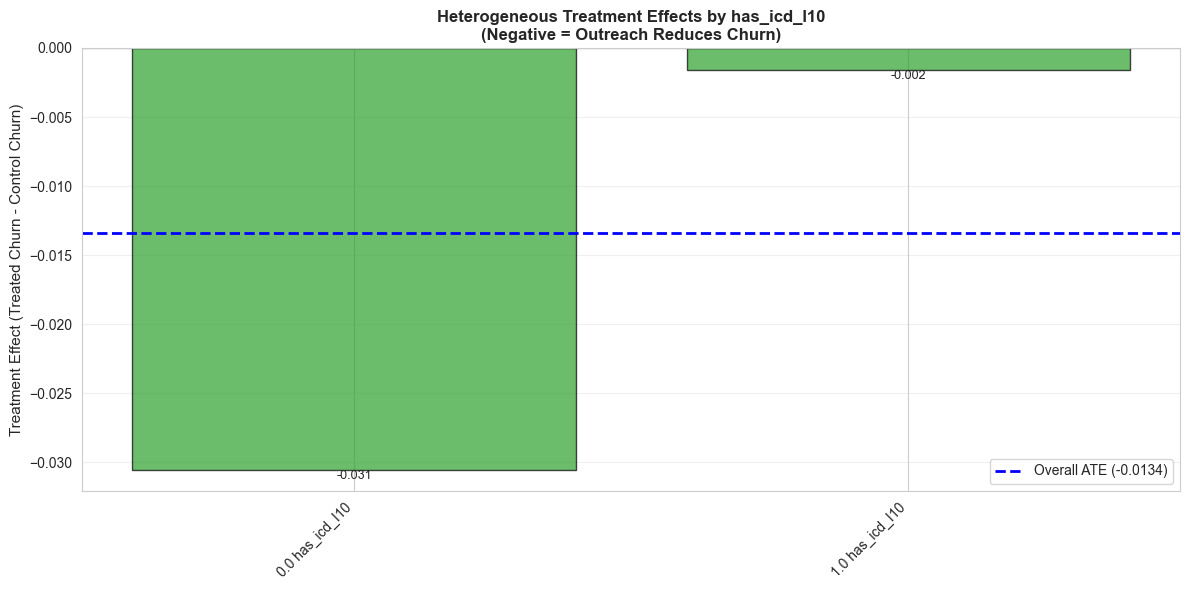


💡 CLINICAL INSIGHT for has_icd_I10:
   ✅ BEST: 0.0 has_icd_I10 shows strongest benefit (ATE=-0.0306)
      → Prioritize outreach for this segment (4113 members)

TREATMENT EFFECT BY HAS_ICD_E11_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_E11_9 -0.024911     4120       1652       2468       0.197942       0.222853
1.0 has_icd_E11_9 -0.005478     5880       2332       3548       0.191252       0.196731

Overall ATE (reference): -0.0134


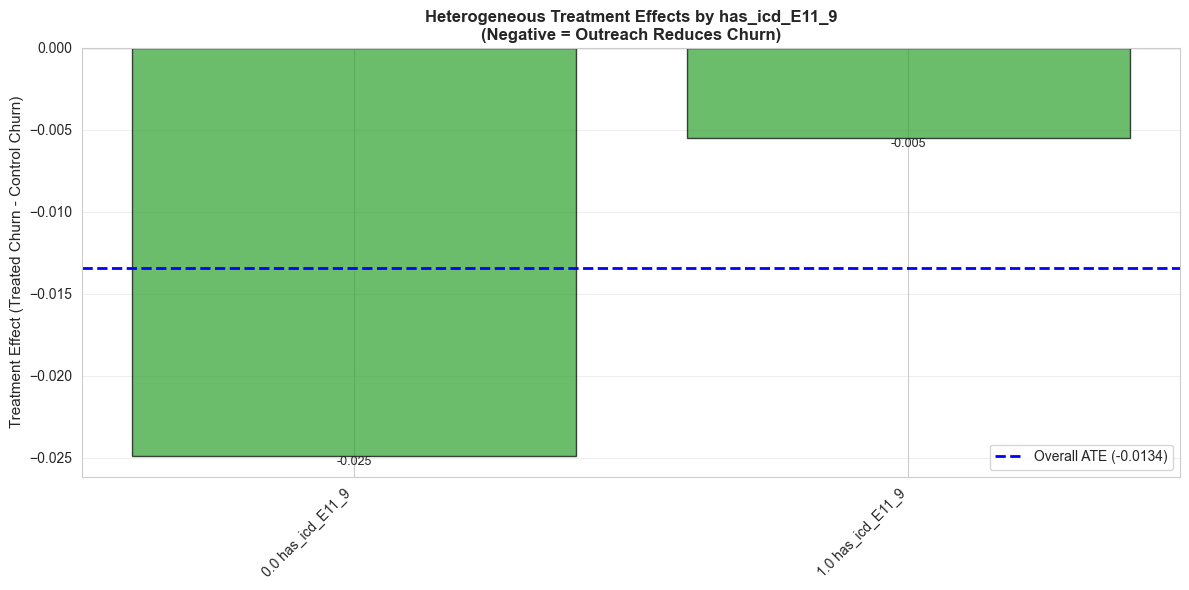


💡 CLINICAL INSIGHT for has_icd_E11_9:
   ✅ BEST: 0.0 has_icd_E11_9 shows strongest benefit (ATE=-0.0249)
      → Prioritize outreach for this segment (4120 members)

TREATMENT EFFECT BY HAS_ICD_K21_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_K21_9 -0.005015     5938       2390       3548       0.197071       0.202086
1.0 has_icd_K21_9 -0.025693     4062       1594       2468       0.189460       0.215154

Overall ATE (reference): -0.0134


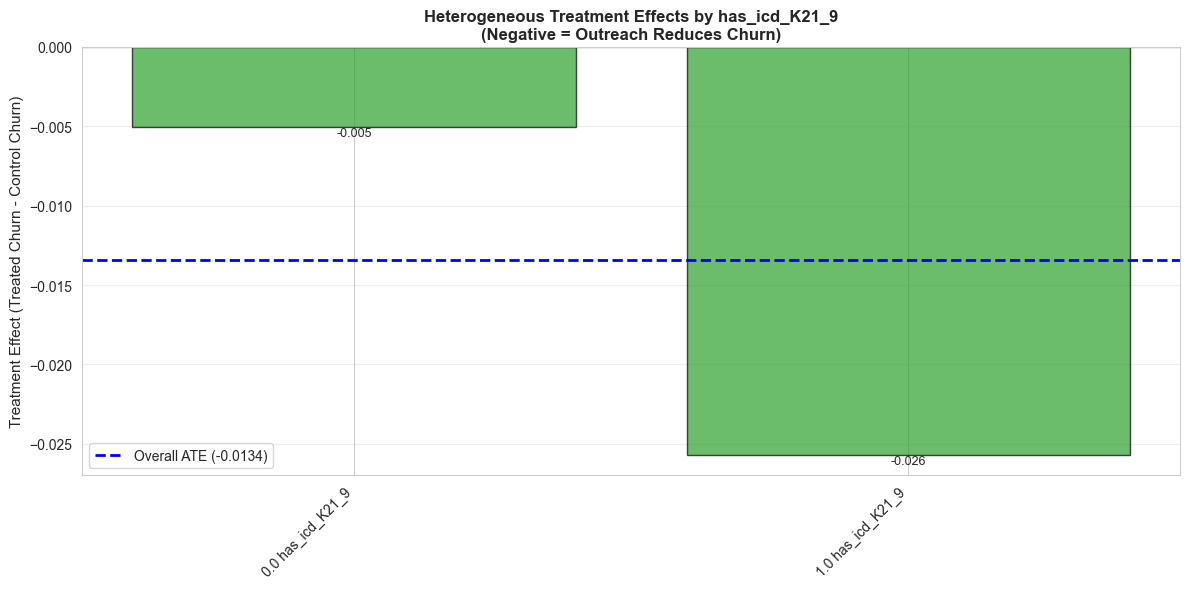


💡 CLINICAL INSIGHT for has_icd_K21_9:
   ✅ BEST: 1.0 has_icd_K21_9 shows strongest benefit (ATE=-0.0257)
      → Prioritize outreach for this segment (4062 members)

TREATMENT EFFECT BY HAS_ICD_R51 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_R51 -0.023992     5957       2373       3584       0.184155       0.208147
1.0 has_icd_R51  0.002152     4043       1611       2432       0.208566       0.206414

Overall ATE (reference): -0.0134


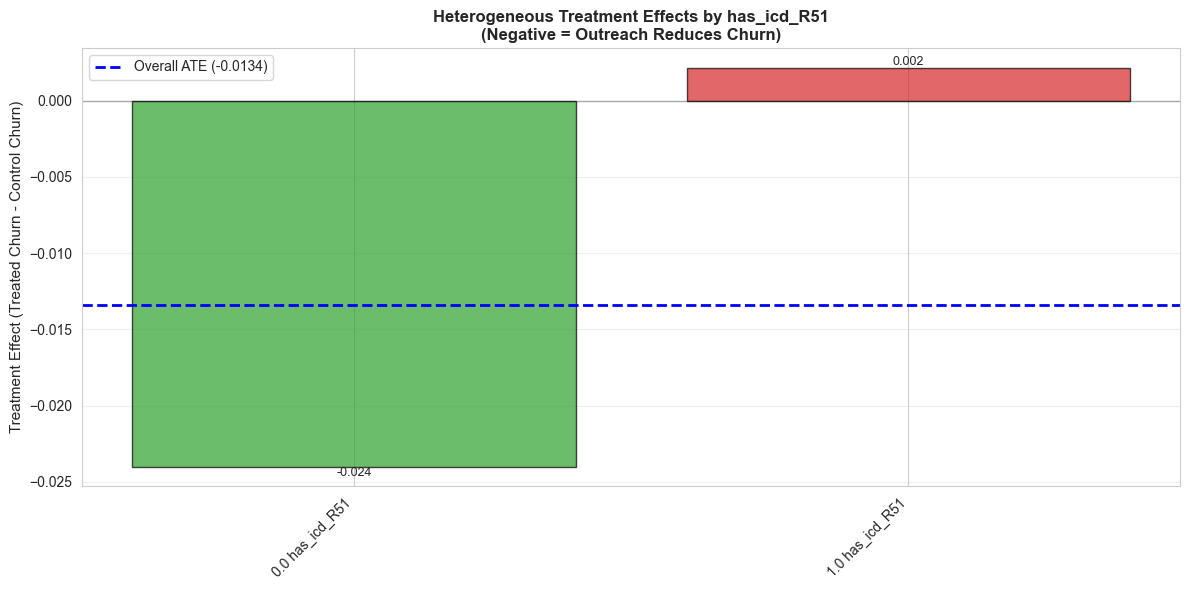


💡 CLINICAL INSIGHT for has_icd_R51:
   ✅ BEST: 0.0 has_icd_R51 shows strongest benefit (ATE=-0.0240)
      → Prioritize outreach for this segment (5957 members)
   ⚠️  WORST: 1.0 has_icd_R51 shows harm/no benefit (ATE=0.0022)
      → Avoid outreach for this segment (4043 members)

TREATMENT EFFECT BY HAS_ICD_A09 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_A09 -0.027053     5861       2289       3572       0.179554       0.206607
1.0 has_icd_A09  0.004895     4139       1695       2444       0.213569       0.208674

Overall ATE (reference): -0.0134


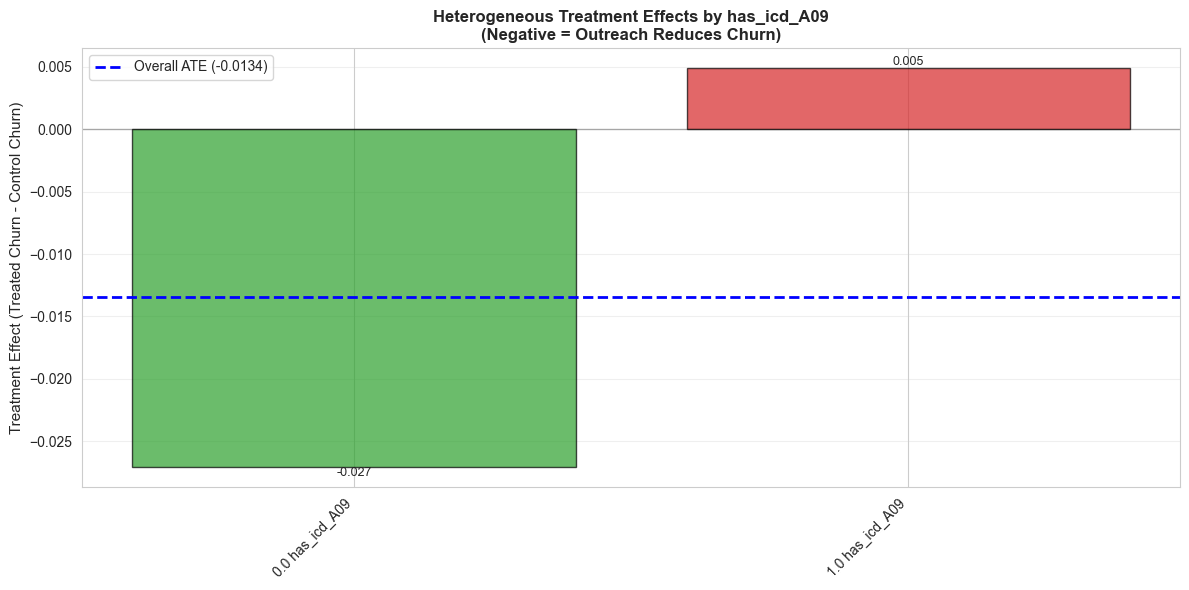


💡 CLINICAL INSIGHT for has_icd_A09:
   ✅ BEST: 0.0 has_icd_A09 shows strongest benefit (ATE=-0.0271)
      → Prioritize outreach for this segment (5861 members)
   ⚠️  WORST: 1.0 has_icd_A09 shows harm/no benefit (ATE=0.0049)
      → Avoid outreach for this segment (4139 members)

TREATMENT EFFECT BY HAS_ICD_B34_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_B34_9 -0.008176     5798       2330       3468       0.198283       0.206459
1.0 has_icd_B34_9 -0.020762     4202       1654       2548       0.188029       0.208791

Overall ATE (reference): -0.0134


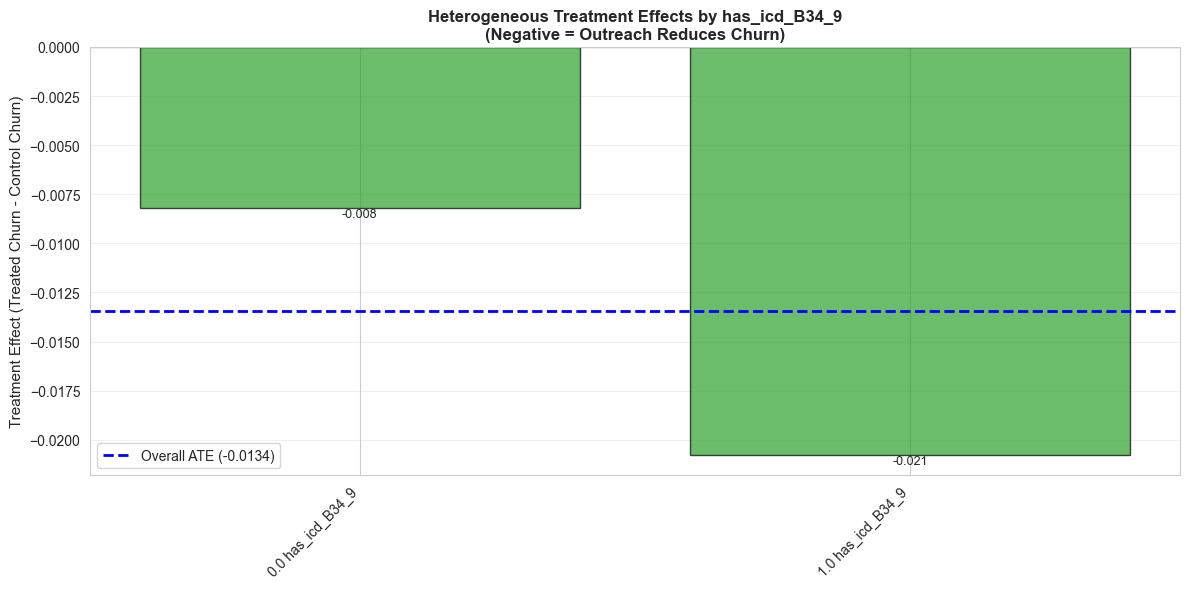


💡 CLINICAL INSIGHT for has_icd_B34_9:
   ✅ BEST: 1.0 has_icd_B34_9 shows strongest benefit (ATE=-0.0208)
      → Prioritize outreach for this segment (4202 members)

TREATMENT EFFECT BY HAS_ICD_H10_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_H10_9 -0.021668     5841       2305       3536       0.189588       0.211256
1.0 has_icd_H10_9 -0.001897     4159       1679       2480       0.200119       0.202016

Overall ATE (reference): -0.0134


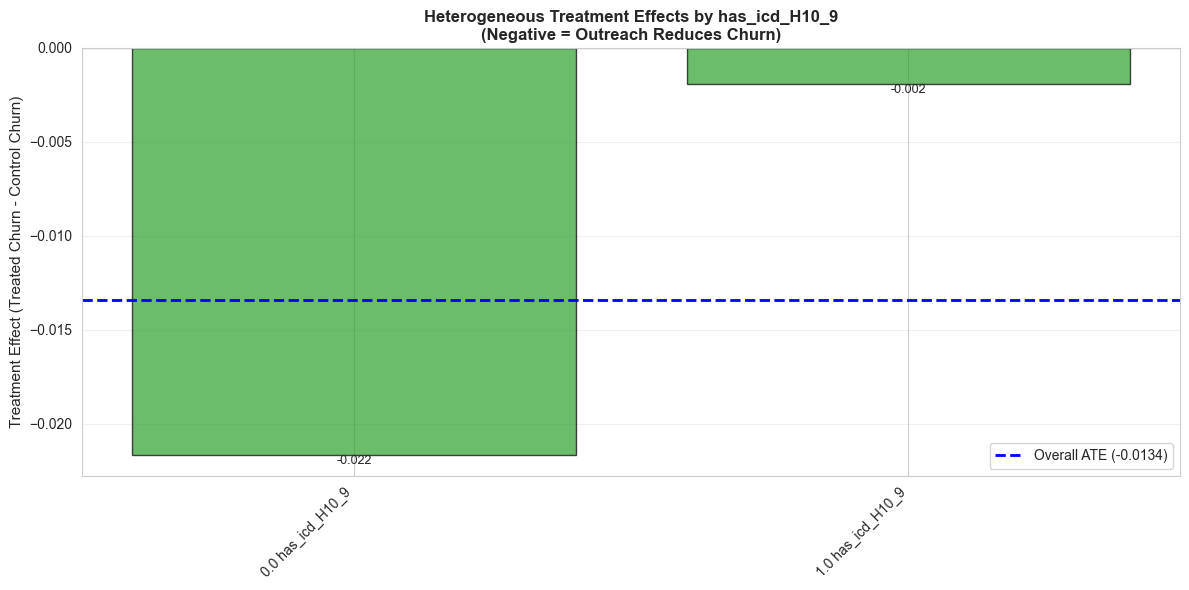


💡 CLINICAL INSIGHT for has_icd_H10_9:
   ✅ BEST: 0.0 has_icd_H10_9 shows strongest benefit (ATE=-0.0217)
      → Prioritize outreach for this segment (5841 members)

TREATMENT EFFECT BY EARLY_CLAIMS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_claims -0.014098     3705       1442       2263       0.205964       0.220062
Medium early_claims -0.028793     4027       1625       2402       0.173538       0.202331
  High early_claims  0.016149     2268        917       1351       0.211559       0.195411

Overall ATE (reference): -0.0134


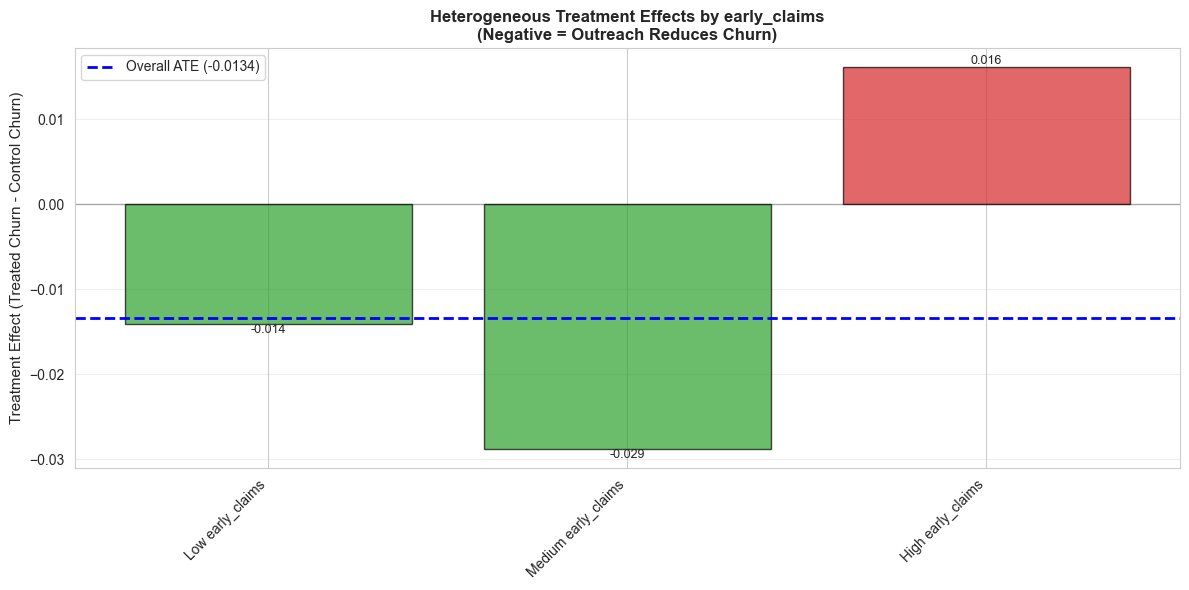


💡 CLINICAL INSIGHT for early_claims:
   ✅ BEST: Medium early_claims shows strongest benefit (ATE=-0.0288)
      → Prioritize outreach for this segment (4027 members)
   ⚠️  WORST: High early_claims shows harm/no benefit (ATE=0.0161)
      → Avoid outreach for this segment (2268 members)

TREATMENT EFFECT BY LATE_CLAIMS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_claims -0.017909     3798       1512       2286       0.197751       0.215661
Medium late_claims -0.023049     3906       1545       2361       0.185761       0.208810
  High late_claims  0.010345     2296        927       1369       0.201726       0.191381

Overall ATE (reference): -0.0134


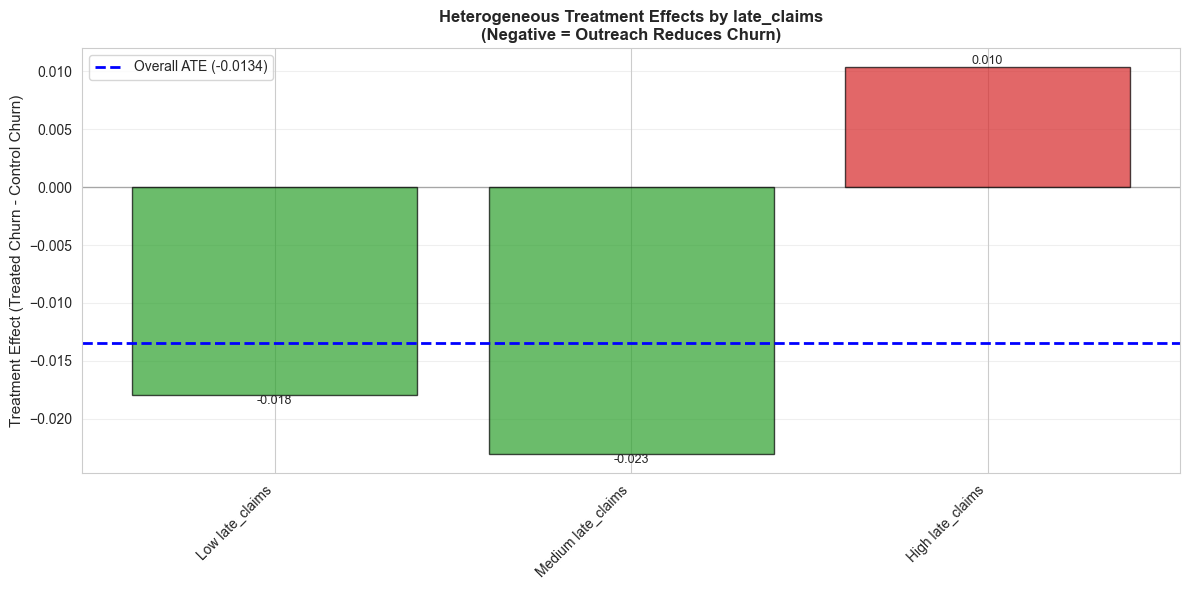


💡 CLINICAL INSIGHT for late_claims:
   ✅ BEST: Medium late_claims shows strongest benefit (ATE=-0.0230)
      → Prioritize outreach for this segment (3906 members)
   ⚠️  WORST: High late_claims shows harm/no benefit (ATE=0.0103)
      → Avoid outreach for this segment (2296 members)

TREATMENT EFFECT BY CLAIM_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low claim_trend -0.019338     4220       1691       2529       0.187463       0.206801
Medium claim_trend -0.010138     3038       1219       1819       0.204266       0.214404
  High claim_trend -0.008102     2742       1074       1668       0.192737       0.200839

Overall ATE (reference): -0.0134


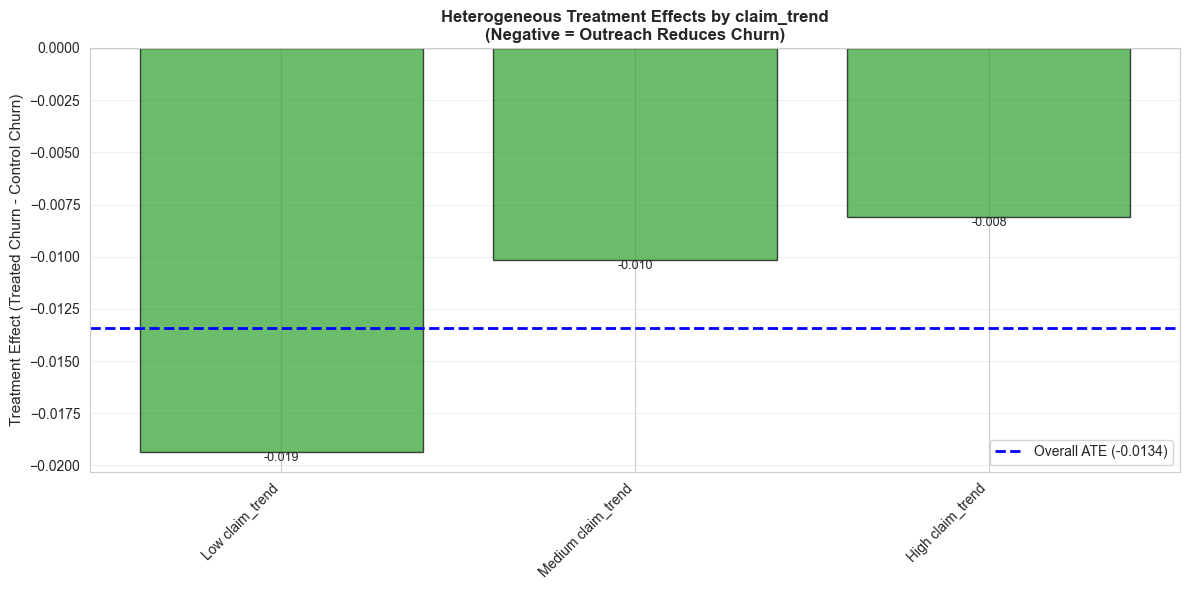


💡 CLINICAL INSIGHT for claim_trend:
   ✅ BEST: Low claim_trend shows strongest benefit (ATE=-0.0193)
      → Prioritize outreach for this segment (4220 members)

SUMMARY: Use these insights to target outreach based on uplift model predictions


In [46]:
## Analyze Heterogeneous Treatment Effects by Segment


# Prepare data with labels
X_train_with_labels = X_train.copy()
X_train_with_labels["churn"] = y_train.values
X_train_with_labels["outreach"] = treatment_train.values

# Calculate overall ATE for reference
overall_ate = (
    y_train[treatment_train == 1].mean() - y_train[treatment_train == 0].mean()
)

# Features to analyze (WellCo clinical priorities)
features_ate = X_train.columns.tolist()

for feature in features_ate:
    if feature not in X_train.columns:
        print(f"\n⚠️  Feature '{feature}' not found in X_train, skipping...")
        continue

    # Check if feature has variation
    if X_train[feature].nunique() <= 1:
        print(f"\n⚠️  Feature '{feature}' has no variation, skipping...")
        continue

    # Handle features with few unique values (binary/categorical)
    unique_vals = X_train[feature].nunique()

    try:
        if unique_vals <= 3:
            # For binary/low-cardinality features, use actual values as segments
            X_train_with_labels[f"{feature}_level"] = X_train[feature].astype(str)
            segments = sorted(X_train_with_labels[f"{feature}_level"].unique())
        else:
            # For continuous features, create tertiles
            X_train_with_labels[f"{feature}_level"] = pd.qcut(
                X_train[feature],
                q=3,
                labels=["Low", "Medium", "High"],
                duplicates="drop",  # Handle tied values
            )
            segments = ["Low", "Medium", "High"]

        # Calculate ATE for each segment
        segment_ates = []
        for segment in segments:
            mask = X_train_with_labels[f"{feature}_level"] == segment

            # Check if we have both treated and control members in this segment
            n_treated = (mask & (treatment_train == 1)).sum()
            n_control = (mask & (treatment_train == 0)).sum()

            if n_treated == 0 or n_control == 0:
                print(
                    f"\n⚠️  Segment '{segment}' has no treated or control members, skipping..."
                )
                continue

            treated_churn = X_train_with_labels.loc[
                mask & (treatment_train == 1), "churn"
            ].mean()
            control_churn = X_train_with_labels.loc[
                mask & (treatment_train == 0), "churn"
            ].mean()

            segment_ate = treated_churn - control_churn
            n_members = mask.sum()

            segment_ates.append(
                {
                    "Segment": f"{segment} {feature}",
                    "ATE": segment_ate,
                    "Members": n_members,
                    "N_Treated": n_treated,
                    "N_Control": n_control,
                    "Treated_Churn": treated_churn,
                    "Control_Churn": control_churn,
                }
            )

        if len(segment_ates) == 0:
            print(f"\n⚠️  No valid segments for '{feature}', skipping...")
            continue

        ate_df = pd.DataFrame(segment_ates)

        # Print results
        print("\n" + "=" * 80)
        print(f"TREATMENT EFFECT BY {feature.upper()} LEVEL")
        print("=" * 80)
        print(ate_df.to_string(index=False))
        print(f"\nOverall ATE (reference): {overall_ate:.4f}")
        print("=" * 80)

        # Visualize
        fig, ax = plt.subplots(figsize=(12, 6))
        x = range(len(ate_df))
        colors = ["#d62728" if ate > 0 else "#2ca02c" for ate in ate_df["ATE"]]

        bars = ax.bar(x, ate_df["ATE"], color=colors, alpha=0.7, edgecolor="black")

        # Add value labels on bars
        for i, (idx, row) in enumerate(ate_df.iterrows()):
            ax.text(
                i,
                row["ATE"],
                f'{row["ATE"]:.3f}',
                ha="center",
                va="bottom" if row["ATE"] > 0 else "top",
                fontsize=9,
            )

        # Reference lines
        ax.axhline(y=0, color="black", linestyle="-", linewidth=1, alpha=0.3)
        ax.axhline(
            y=overall_ate,
            color="blue",
            linestyle="--",
            linewidth=2,
            label=f"Overall ATE ({overall_ate:.4f})",
        )

        ax.set_xticks(x)
        ax.set_xticklabels(ate_df["Segment"], rotation=45, ha="right")
        ax.set_ylabel("Treatment Effect (Treated Churn - Control Churn)", fontsize=11)
        ax.set_title(
            f"Heterogeneous Treatment Effects by {feature}\n(Negative = Outreach Reduces Churn)",
            fontsize=12,
            fontweight="bold",
        )
        ax.legend(loc="best")
        ax.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Clinical interpretation for WellCo
        print(f"\n💡 CLINICAL INSIGHT for {feature}:")
        best_segment = ate_df.loc[ate_df["ATE"].idxmin()]
        worst_segment = ate_df.loc[ate_df["ATE"].idxmax()]

        if best_segment["ATE"] < overall_ate:
            print(
                f"   ✅ BEST: {best_segment['Segment']} shows strongest benefit (ATE={best_segment['ATE']:.4f})"
            )
            print(
                f"      → Prioritize outreach for this segment ({best_segment['Members']} members)"
            )

        if worst_segment["ATE"] > 0:
            print(
                f"   ⚠️  WORST: {worst_segment['Segment']} shows harm/no benefit (ATE={worst_segment['ATE']:.4f})"
            )
            print(
                f"      → Avoid outreach for this segment ({worst_segment['Members']} members)"
            )

    except Exception as e:
        print(f"\n❌ Error processing '{feature}': {str(e)}")
        continue

print("\n" + "=" * 80)
print(
    "SUMMARY: Use these insights to target outreach based on uplift model predictions"
)
print("=" * 80)

## training

In [47]:
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

In [48]:

def compare_train_test_performance(
    model, X_tr, X_te, y_tr, y_te, t_tr, t_te, model_name="Model"
):
    """Compare model performance on train vs test to detect overfitting"""

    # Predict on both sets
    uplift_train = model.predict(X_tr)
    uplift_test = model.predict(X_te)

    # Calculate Qini AUC
    qini_train = qini_auc_score(y_tr, uplift_train, t_tr)
    qini_test = qini_auc_score(y_te, uplift_test, t_te)

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    from sklift.viz import plot_qini_curve

    plot_qini_curve(y_tr, uplift_train, t_tr, perfect=True, name="Train", ax=ax1)
    ax1.set_title(f"{model_name} - Train (Qini AUC: {qini_train:.4f})")

    plot_qini_curve(y_te, uplift_test, t_te, perfect=True, name="Test", ax=ax2)
    ax2.set_title(f"{model_name} - Test (Qini AUC: {qini_test:.4f})")

    plt.tight_layout()
    plt.show()

    # Calculate overfitting gap
    gap = qini_train - qini_test
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"Train Qini AUC: {qini_train:.4f}")
    print(f"Test Qini AUC:  {qini_test:.4f}")
    print(f"Overfitting Gap: {gap:.4f} ({gap/qini_train*100:.1f}% relative)")

    if gap > 0.01:
        print("⚠️  WARNING: Significant overfitting detected!")
    elif gap > 0.005:
        print("⚠️  Mild overfitting detected")
    else:
        print("✅ Good generalization")
    print(f"{'='*60}\n")

    return qini_train, qini_test, gap




In [49]:
## Elastic Net Logistic Regression

logistic_elasticnet = LogisticRegression(
    random_state=42,
    max_iter=5000,
    class_weight="balanced",
    penalty="elasticnet",  # Mix of L1 and L2
    solver="saga",
    C=0.2,
    l1_ratio=0.1,  # 0.5 = equal mix of L1 and L2
)

slearner_logistic_enet = SoloModel(estimator=logistic_elasticnet)
slearner_logistic_enet.fit(X_train, y_train, treatment=treatment_train)

uplift_test_enet = slearner_logistic_enet.predict(X_test)
test_qini_enet = qini_auc_score(y_test, uplift_test_enet, treatment_test)
print(f"Elastic Net Logistic Test Qini AUC: {test_qini_enet:.4f}")
uplift_train_enet = slearner_logistic_enet.predict(X_train)
train_qini_enet = qini_auc_score(y_train, uplift_train_enet, treatment_train)
print(f"Elastic Net Logistic Train Qini AUC: {train_qini_enet:.4f}")

Elastic Net Logistic Test Qini AUC: 0.0508
Elastic Net Logistic Train Qini AUC: 0.0223


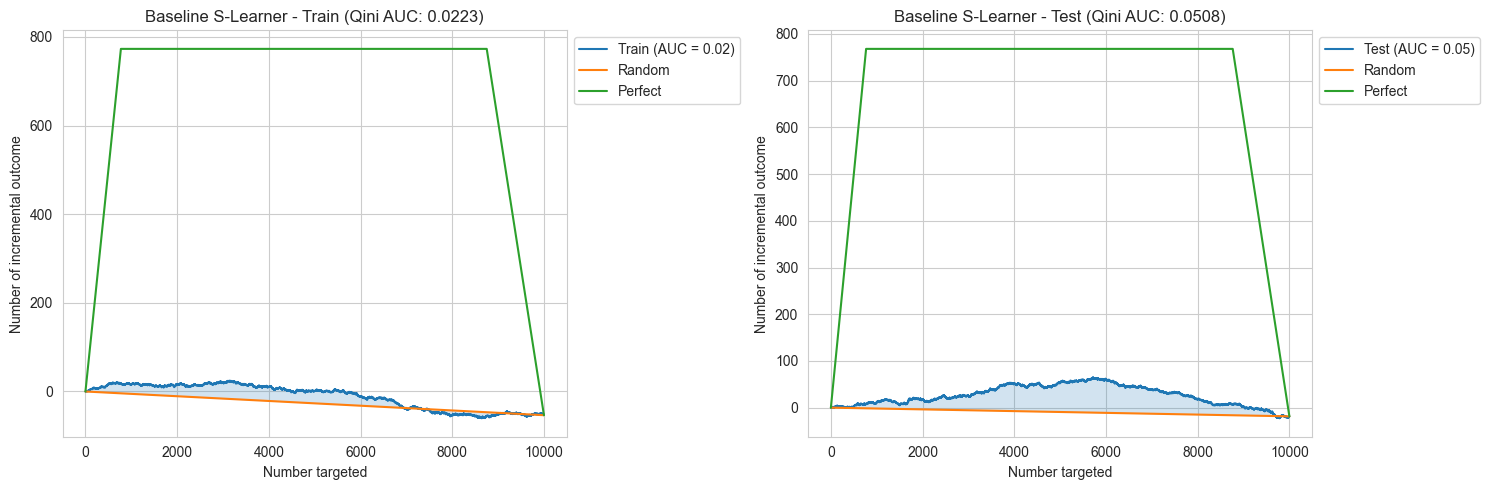


Model: Baseline S-Learner
Train Qini AUC: 0.0223
Test Qini AUC:  0.0508
Overfitting Gap: -0.0285 (-127.8% relative)
✅ Good generalization



(0.02228616800623734, 0.050766493737781665, -0.028480325731544326)

In [50]:
compare_train_test_performance(
    slearner_logistic_enet,
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    model_name="Baseline S-Learner",
)

In [51]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklift.models import ClassTransformation
from sklift.viz import plot_qini_curve
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1️⃣ Compute propensity scores
# ------------------------------------------------------------
def compute_propensity(X_train, X_test, treatment_train):
    prop_model = LGBMClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        random_state=42,
    )
    prop_model.fit(X_train, treatment_train)
    p_train = prop_model.predict_proba(X_train)[:, 1]
    p_test = prop_model.predict_proba(X_test)[:, 1]
    return p_train, p_test


# ------------------------------------------------------------
# 2️⃣ Train TLearner (ClassTransformation)
# ------------------------------------------------------------
def train_tlearner_sk(X_train, y_train, treatment_train):
    base_model = LGBMClassifier(
        n_estimators=150,  # fewer trees
        max_depth=3,  # shallower
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=42,
    )
    uplift_model = ClassTransformation(base_model)
    uplift_model.fit(X_train, y_train, treatment_train)
    return uplift_model


# ------------------------------------------------------------
# 3️⃣ Predict uplift (flip for churn)
# ------------------------------------------------------------
def predict_uplift(uplift_model, X, flip_for_churn=True):
    uplift_scores = uplift_model.predict(X)
    if flip_for_churn:
        uplift_scores = -uplift_scores
    return uplift_scores


# ------------------------------------------------------------
# 4️⃣ Compute normalized Qini AUC (0–1)
# ------------------------------------------------------------
def compute_normalized_qini(y, treatment, uplift_scores):
    df = pd.DataFrame({"y": y, "t": treatment, "uplift": uplift_scores}).sort_values(
        "uplift", ascending=False
    )

    # cumulative gain for treated vs control
    df["cum_gain_treated"] = (df["y"] * df["t"]).cumsum()
    df["cum_gain_control"] = (df["y"] * (1 - df["t"])).cumsum()
    df["qini"] = df["cum_gain_treated"] - df["cum_gain_control"]

    max_qini = df["qini"].max()
    if max_qini != 0:
        normalized_qini = np.trapz(df["qini"] / max_qini) / len(df)  # 0–1 scale
    else:
        normalized_qini = 0.0
    return normalized_qini


# ------------------------------------------------------------
# 5️⃣ Plot Qini curve + return normalized AUC
# ------------------------------------------------------------
def plot_qini_and_auc(y_test, treatment_test, uplift_scores, name="Model"):
    disp = plot_qini_curve(
        y_test, uplift_scores, treatment_test, perfect=True, name=name
    )
    disp.figure_.suptitle("Qini Curve")
    plt.show()

    normalized_qini_auc = compute_normalized_qini(y_test, treatment_test, uplift_scores)
    print(f"🎯 Normalized Qini AUC = {normalized_qini_auc:.4f}")
    return disp, normalized_qini_auc


# ------------------------------------------------------------
# 6️⃣ Select top N% uplifted customers
# ------------------------------------------------------------
def select_top_customers(X_test, uplift_scores, top_pct=0.2):
    n_top = int(len(X_test) * top_pct)
    top_idx = np.argsort(uplift_scores)[-n_top:]
    return X_test.iloc[top_idx].copy(), uplift_scores[top_idx]


# ------------------------------------------------------------
# 7️⃣ Full pipeline
# ------------------------------------------------------------
def stable_uplift_pipeline_sk(
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    flip_for_churn=False,
    top_pct=None,
):
    print("Step 1: Compute propensity scores...")
    p_train, p_test = compute_propensity(X_train, X_test, treatment_train)

    # add propensity score feature
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()
    X_train_["propensity_score"] = p_train
    X_test_["propensity_score"] = p_test

    print("Step 2: Train TLearner uplift model (sklift)...")
    uplift_model = train_tlearner_sk(X_train_, y_train, treatment_train)

    print("Step 3: Predict uplift (flip for churn)...")
    uplift_scores = predict_uplift(uplift_model, X_test_, flip_for_churn=flip_for_churn)

    print("Step 4: Plot Qini and compute normalized Qini AUC...")
    disp, normalized_qini_auc = plot_qini_and_auc(y_test, treatment_test, uplift_scores)

    top_customers = None
    if top_pct is not None:
        print(f"Selecting top {int(top_pct*100)}% uplifted customers...")
        top_customers, top_scores = select_top_customers(
            X_test_, uplift_scores, top_pct
        )
        print(f"Selected {len(top_customers)} customers for outreach.")

    return uplift_model, uplift_scores, disp, normalized_qini_auc, top_customers

Step 1: Compute propensity scores...
[LightGBM] [Info] Number of positive: 3984, number of negative: 6016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398400 -> initscore=-0.412136
[LightGBM] [Info] Start training from score -0.412136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

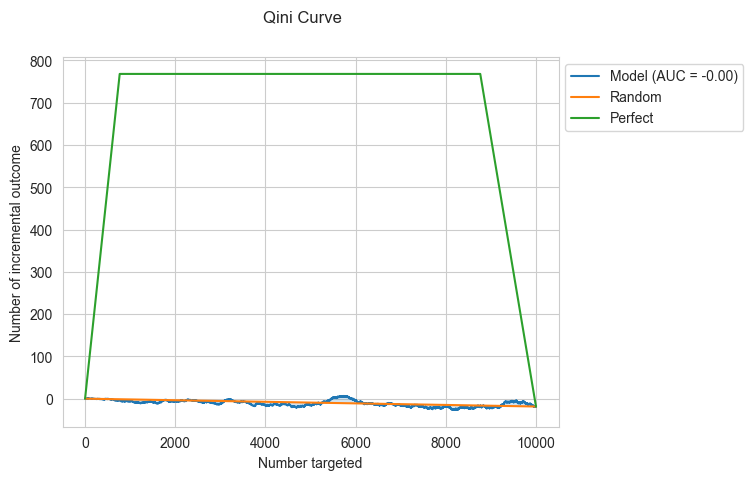

🎯 Normalized Qini AUC = 0.0000
Selecting top 20% uplifted customers...
Selected 2000 customers for outreach.


In [52]:
uplift_model, uplift_scores, disp, qini_auc, top_customers = stable_uplift_pipeline_sk(
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    top_pct=0.2,  # optional: select top 20% uplifted customers
)


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.044921
  Max: -0.018577
  Range: 0.026345
  Mean: -0.042287
  Std: 0.003353

⚠️  ISSUE: Very narrow uplift range (0.026345)
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


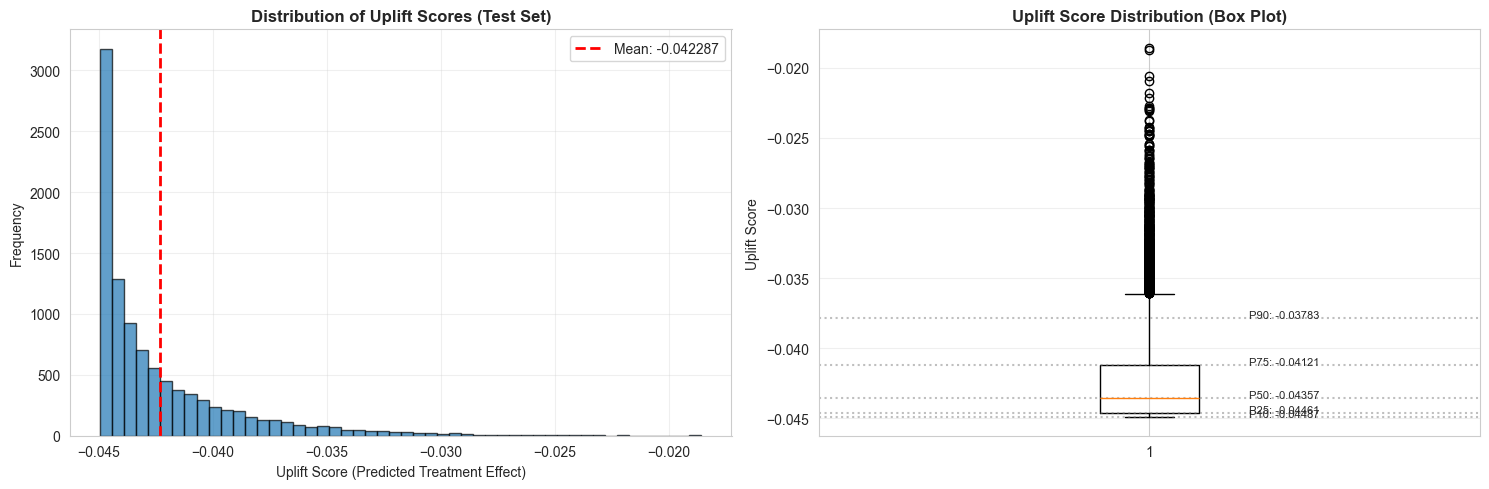


✅ Distribution plot saved to: outputs/uplift_distribution_20251116T205207Z.png


In [53]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {uplift_test_enet.min():.6f}")
print(f"  Max: {uplift_test_enet.max():.6f}")
print(f"  Range: {uplift_test_enet.max() - uplift_test_enet.min():.6f}")
print(f"  Mean: {uplift_test_enet.mean():.6f}")
print(f"  Std: {uplift_test_enet.std():.6f}")

print(
    f"\n⚠️  ISSUE: Very narrow uplift range ({uplift_test_enet.max() - uplift_test_enet.min():.6f})"
)
print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(uplift_test_enet, bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(
    uplift_test_enet.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {uplift_test_enet.mean():.6f}",
)
ax1.set_xlabel("Uplift Score (Predicted Treatment Effect)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Uplift Scores (Test Set)", fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot with percentiles
ax2.boxplot(uplift_test_enet, vert=True)
ax2.set_ylabel("Uplift Score")
ax2.set_title("Uplift Score Distribution (Box Plot)", fontweight="bold")
ax2.grid(alpha=0.3, axis="y")

# Add percentile annotations
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(uplift_test_enet, p)
    ax2.axhline(val, color="gray", linestyle=":", alpha=0.5)
    ax2.text(1.15, val, f"P{p}: {val:.5f}", fontsize=8)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"uplift_distribution_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✅ Distribution plot saved to: outputs/uplift_distribution_{timestamp}.png")
print("=" * 80)

# econml

Training DRLearner on training set...


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l


Top 5 Ranked Members (Test Set):
   member_id  prioritization_score  rank
0       6284              0.690073     1
1        468              0.626352     2
2       3967              0.619847     3
3       2114              0.608939     4
4       9758              0.607898     5

--- Uplift Model Metrics (Test Set) ---
Total Theoretical Uplift Gain: 18.5822
Area Under the Uplift Curve (AUUC, Normalized): -10.225084
--- Uplift Model Metrics (Test Set) ---


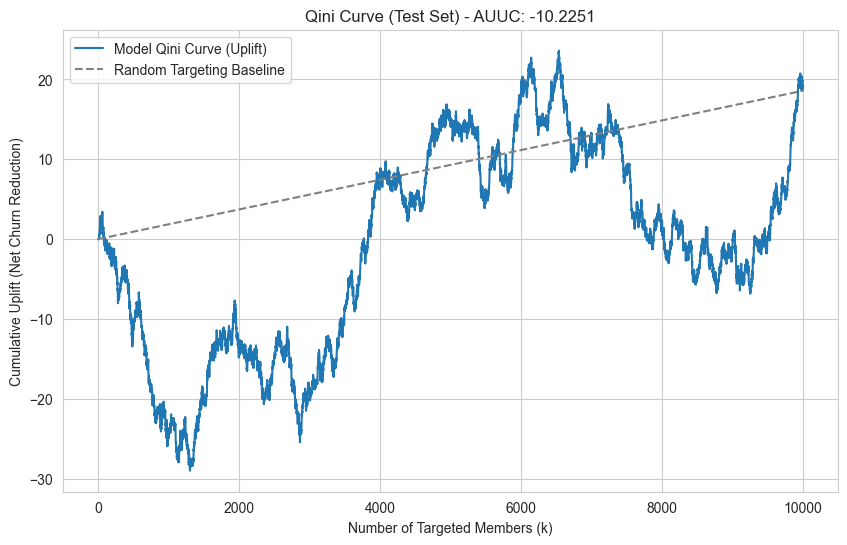

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from econml.dr import DRLearner
from sklearn.linear_model import LogisticRegression

# ----------------------------------------------------------------------
# 1. Data Loading and Preparation 
df_test = pd.DataFrame(
    {
        "churn": y_test,
        "outreach": treatment_test,
        "member_id": np.arange(10000),  # Placeholder member IDs
    }
)
# -------------------------------------------------

# ----------------------------------------------------------------------
# 2. EconML Model Training (DRLearner) - Corrected
# ----------------------------------------------------------------------

# Define the models
model_propensity = LogisticRegression(solver="lbfgs")  # P(T|X)
# IMPORTANT: Added model_regression for E[Y|X, T], using Regressor for continuous Y
model_regression = RandomForestRegressor(
    n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42
)
model_final = GradientBoostingRegressor(
    n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42
)  # Final CATE Estimator (tau(X))

# DRLearner model instance - Using correct parameters: model_propensity and model_regression
dr_learner = DRLearner(
    model_final=model_final,
    model_propensity=model_propensity,  # Corrected from 'model_t'
    model_regression=model_regression,  # Added for complete doubly robust estimation
    cv=5,
    mc_iters=3,
    random_state=42,
)

print("Training DRLearner on training set...")
# Fit the model using the training data
dr_learner.fit(
    Y=y_train,
    T=treatment_train,
    X=X_train,
    W=None,  # Assuming no features W that only affect the outcome, not the treatment effect
)

# ----------------------------------------------------------------------
# 3. CATE Prediction (Uplift Score) - Using Test Data
# ----------------------------------------------------------------------

# Predict CATE on the held-out TEST set
cate_pred_test = dr_learner.effect(X_test)

# NOTE: Uplift Score = -CATE for churn prevention (Higher score is better)
prioritization_score_test = -cate_pred_test

# Add results to the test DataFrame
df_results_test = df_test.copy()
df_results_test["prioritization_score"] = prioritization_score_test

# Sort and Rank the test members
df_results_test = df_results_test.sort_values(
    by="prioritization_score", ascending=False
).reset_index(drop=True)
df_results_test["rank"] = df_results_test.index + 1

# Output the required ranked list
top_n_members_test = df_results_test[["member_id", "prioritization_score", "rank"]]
print("\nTop 5 Ranked Members (Test Set):")
print(top_n_members_test.head())
top_n_members_test.to_csv("ranked_members_for_outreach_test.csv", index=False)

# ----------------------------------------------------------------------
# 4. Qini/AUUC Calculation and Plotting (Using Test Data)
# ----------------------------------------------------------------------


def calculate_qini_auuc(
    df, score_col="prioritization_score", uplift_col="churn", treatment_col="outreach"
):
    """Calculates Qini curve and Area Under the Uplift Curve (AUUC)."""

    # Sort the data by the prioritization score
    df_sorted = df.sort_values(by=score_col, ascending=False).reset_index(drop=True)

    N_total = len(df_sorted)
    qini_data = []

    # Calculate Total Uplift Gain for Baseline
    N_treated_total = df_sorted[treatment_col].sum()
    mean_churn_control_total = df_sorted[df_sorted[treatment_col] == 0][
        uplift_col
    ].mean()
    mean_churn_treated_total = df_sorted[df_sorted[treatment_col] == 1][
        uplift_col
    ].mean()
    qini_gain_total = (
        mean_churn_control_total - mean_churn_treated_total
    ) * N_treated_total

    for k in range(1, N_total + 1):
        df_k = df_sorted.head(k)
        y_treated = df_k[df_k[treatment_col] == 1][uplift_col]
        y_control = df_k[df_k[treatment_col] == 0][uplift_col]

        N_treated_k = len(y_treated)

        if N_treated_k > 0 and len(y_control) > 0:
            mean_churn_control = y_control.mean()
            mean_churn_treated = y_treated.mean()
            # Qini Gain: (P(Yc|Xk) - P(Yt|Xk)) * N_treated_k
            qini_gain = (mean_churn_control - mean_churn_treated) * N_treated_k
        else:
            qini_gain = 0

        qini_data.append({"k": k, "qini_gain": qini_gain})

    df_qini = pd.DataFrame(qini_data)

    # Calculate AUUC (Area between model curve and random baseline)
    df_qini["random_gain"] = df_qini["k"] / N_total * qini_gain_total
    auuc = (
        np.trapz(
            df_qini["qini_gain"].values - df_qini["random_gain"].values,
            df_qini["k"].values,
        )
        / N_total
    )

    return df_qini, auuc, qini_gain_total


# Calculate and plot the results
df_qini_test, auuc_score_test, total_uplift_gain_test = calculate_qini_auuc(
    df_results_test
)

# Plotting the Qini Curve
plt.figure(figsize=(10, 6))
plt.plot(
    df_qini_test["k"], df_qini_test["qini_gain"], label="Model Qini Curve (Uplift)"
)
plt.plot(
    df_qini_test["k"],
    df_qini_test["random_gain"],
    linestyle="--",
    color="gray",
    label="Random Targeting Baseline",
)

plt.title(f"Qini Curve (Test Set) - AUUC: {auuc_score_test:.4f}")
plt.xlabel("Number of Targeted Members (k)")
plt.ylabel("Cumulative Uplift (Net Churn Reduction)")
plt.legend()
plt.grid(True)
plt.savefig("qini_curve_test.png")
print(f"\n--- Uplift Model Metrics (Test Set) ---")
print(f"Total Theoretical Uplift Gain: {total_uplift_gain_test:.4f}")
print(f"Area Under the Uplift Curve (AUUC, Normalized): {auuc_score_test:.6f}")
print("--- Uplift Model Metrics (Test Set) ---")


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.690073
  Max: 0.479807
  Range: 1.169879
  Mean: -0.037005
  Std: 0.077739
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


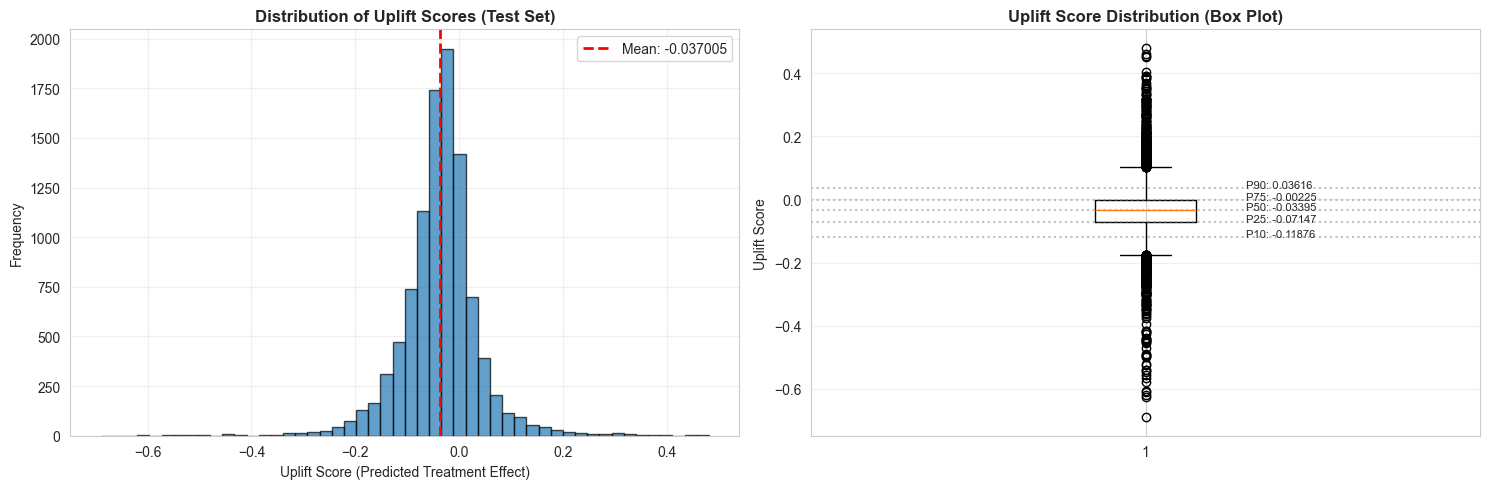


✅ Distribution plot saved to: outputs/uplift_distribution_20251116T205207Z.png


In [55]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {cate_pred_test.min():.6f}")
print(f"  Max: {cate_pred_test.max():.6f}")
print(f"  Range: {cate_pred_test.max() - cate_pred_test.min():.6f}")
print(f"  Mean: {cate_pred_test.mean():.6f}")
print(f"  Std: {cate_pred_test.std():.6f}")

print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(cate_pred_test, bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(
    cate_pred_test.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {cate_pred_test.mean():.6f}",
)
ax1.set_xlabel("Uplift Score (Predicted Treatment Effect)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Uplift Scores (Test Set)", fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot with percentiles
ax2.boxplot(cate_pred_test, vert=True)
ax2.set_ylabel("Uplift Score")
ax2.set_title("Uplift Score Distribution (Box Plot)", fontweight="bold")
ax2.grid(alpha=0.3, axis="y")

# Add percentile annotations
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(cate_pred_test, p)
    ax2.axhline(val, color="gray", linestyle=":", alpha=0.5)
    ax2.text(1.15, val, f"P{p}: {val:.5f}", fontsize=8)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"uplift_distribution_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✅ Distribution plot saved to: outputs/uplift_distribution_{timestamp}.png")
print("=" * 80)